# Imports and setup

### Auto-re-import python modules, useful for editing local fils

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import itertools
import warnings
from collections import Counter

import matplotlib as mpl
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.metrics import (
    DetCurveDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    accuracy_score,
    average_precision_score,
    balanced_accuracy_score,
    classification_report,
    det_curve,
    f1_score,
    precision_recall_curve,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    top_k_accuracy_score,
)

pd.options.display.max_columns = 100

mpl.rcParams["figure.max_open_warning"] = 0

In [7]:
assert pl.__version__ == "1.9.0"

# Read in data

In [8]:
analysis_outdir = (
    "s3://seanome-kmerseek/scope-benchmark/analysis-outputs/2024-10-09__protein_k5-20"
)

### ~Explore with protein, k=7~

In [10]:
# Skip ksizes 5 and 6 for now because those files are enormous, 2.3 GiB for k=5 and 175 MiB for k=6
# -> Figure out how to use polars later
ksizes = range(7, 21)

In [136]:
ksize = 7
# pq = make_multisearch_pq(ksize, analysis_outdir, "protein")
# multisearch = pd.read_parquet(pq)
# print(multisearch.shape)
# multisearch.head()

In [22]:
lineage_cols = ["family", "superfamily", "fold", "class"]

## Explore with hp, ksize=20

In [12]:
! aws s3 ls s3://seanome-kmerseek/scope-benchmark/analysis-outputs/2024-10-09__hp_k20-60/00_cleaned_multisearch_results/

2024-10-11 01:17:53   10651873 scope40.multisearch.hp.k24.filtered.pq
2024-10-11 01:17:52   19449323 scope40.multisearch.hp.k24.pq
2024-10-11 01:17:58    5893593 scope40.multisearch.hp.k25.filtered.pq
2024-10-11 01:17:57   11495754 scope40.multisearch.hp.k25.pq
2024-10-11 01:15:06   10651873 scope40.multisearch.protein.k24.filtered.pq
2024-10-11 01:15:05   19449323 scope40.multisearch.protein.k24.pq
2024-10-11 01:15:10    5893593 scope40.multisearch.protein.k25.filtered.pq
2024-10-11 01:15:09   11495754 scope40.multisearch.protein.k25.pq
2024-10-11 01:15:13    3262063 scope40.multisearch.protein.k26.filtered.pq
2024-10-11 01:15:12    7462970 scope40.multisearch.protein.k26.pq
2024-10-11 01:15:15    2171794 scope40.multisearch.protein.k27.filtered.pq
2024-10-11 01:15:15    5295384 scope40.multisearch.protein.k27.pq


In [15]:
! aws s3 ls s3://seanome-kmerseek/scope-benchmark/analysis-outputs/

                           PRE 2024-10-09__hp_k20-60/
                           PRE 2024-10-09__protein_k5-20/


In [18]:
# ! aws s3 ls s3://seanome-kmerseek/scope-benchmark/analysis-outputs/2024-10-09__protein_k5-20/00_cleaned_multisearch_results/

In [25]:
# def make_multisearch_pq(
#     ksize,
#     outdir,
#     moltype,
# ):
#     basename = f"scope40.multisearch.{moltype}.k{ksize}.pq"
#     pq = f"{outdir}/00_cleaned_multisearch_results/{basename}"
#     return pq


pq = "s3://seanome-kmerseek/scope-benchmark/analysis-outputs/2024-10-09__hp_k20-60/00_cleaned_multisearch_results/scope40.multisearch.hp.k20.filtered.pq"
multisearch = pd.read_parquet(pq)
multisearch["prob_overlap_adjusted_inverse"] = 1 / multisearch["prob_overlap_adjusted"]
print(multisearch.shape)
multisearch.head()

(1761706, 32)


,query_name,query_md5,match_name,match_md5,containment,max_containment,jaccard,intersect_hashes,prob_overlap,prob_overlap_adjusted,containment_adjusted,containment_adjusted_log10,tf_idf_score,query_scop_id,query_scop_lineage,query_scop_lineage_fixed,query_family,query_superfamily,query_fold,query_class,match_scop_id,match_scop_lineage,match_scop_lineage_fixed,match_family,match_superfamily,match_fold,match_class,same_family,same_superfamily,same_fold,same_class,prob_overlap_adjusted_inverse
2,d2fcwa1 a.13.1.1 (A:216-320) alpha-2-Macroglob...,e6ac707cdd74e7c0bdffe2ec104b1cea,d4j42a_ a.25.3.0 (A:) automated matches {Bacil...,429b50d612d737b387bab434a8ff53b1,0.034884,0.049180,0.020833,3.0,1.736790e-11,0.004001,8.719740,0.940504,0.303089,d2fcwa1,a.13.1.1,a.13.1.1,a.13.1.1,a.13.1,a.13,a,d4j42a_,a.25.3.0,a.25.3.0,a.25.3.0,a.25.3,a.25,a,False,False,False,True,249.965886
3,d6d5xa_ a.25.2.0 (A:) automated matches {Human...,ad230364a72799163d9e8eb34d3f4160,d4j42a_ a.25.3.0 (A:) automated matches {Bacil...,429b50d612d737b387bab434a8ff53b1,0.028169,0.065574,0.020101,4.0,1.989414e-11,0.004582,6.147160,0.788675,0.247069,d6d5xa_,a.25.2.0,a.25.2.0,a.25.2.0,a.25.2,a.25,a,d4j42a_,a.25.3.0,a.25.3.0,a.25.3.0,a.25.3,a.25,a,False,False,True,True,218.224186
8,d4dlla2 a.100.1.0 (A:191-316) automated matche...,892f25011eb07e4a98cf99b6a5785b24,d4j42a_ a.25.3.0 (A:) automated matches {Bacil...,429b50d612d737b387bab434a8ff53b1,0.018692,0.032787,0.012048,2.0,7.105051e-12,0.001637,11.421079,1.057707,0.167505,d4dlla2,a.100.1.0,a.100.1.0,a.100.1.0,a.100.1,a.100,a,d4j42a_,a.25.3.0,a.25.3.0,a.25.3.0,a.25.3,a.25,a,False,False,False,True,611.027722
12,d1n4ka1 a.118.22.1 (A:436-602) IP3 receptor ty...,5a73d8ef1d497161dda842a31cb6213f,d4j42a_ a.25.3.0 (A:) automated matches {Bacil...,429b50d612d737b387bab434a8ff53b1,0.027027,0.065574,0.019512,4.0,2.131515e-11,0.004910,5.504754,0.740738,0.235821,d1n4ka1,a.118.22.1,a.118.22.1,a.118.22.1,a.118.22,a.118,a,d4j42a_,a.25.3.0,a.25.3.0,a.25.3.0,a.25.3,a.25,a,False,False,False,True,203.675907
15,d6s7ja_ a.127.1.0 (A:) automated matches {Trep...,63a7a4cd3cb81a25bf7cd92c5674fc99,d4j42a_ a.25.3.0 (A:) automated matches {Bacil...,429b50d612d737b387bab434a8ff53b1,0.004184,0.032787,0.003724,2.0,8.210281e-12,0.001891,2.212443,0.344872,0.037029,d6s7ja_,a.127.1.0,a.127.1.0,a.127.1.0,a.127.1,a.127,a,d4j42a_,a.25.3.0,a.25.3.0,a.25.3.0,a.25.3,a.25,a,False,False,False,True,528.773990


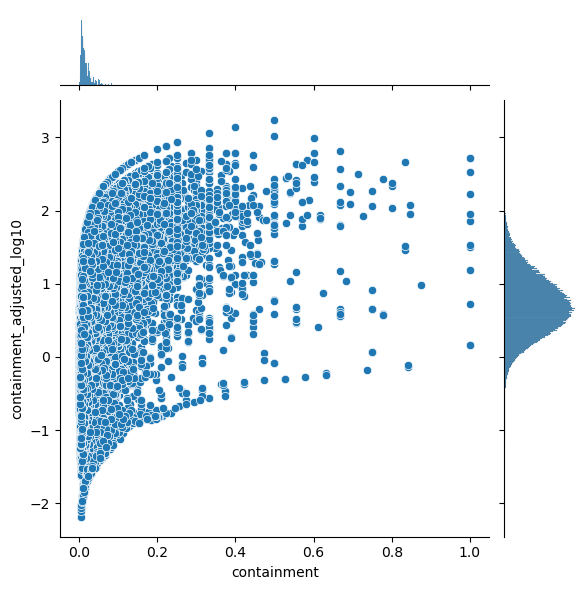

In [21]:
sns.jointplot(multisearch, x="containment", y="containment_adjusted_log10")

/home/ec2-user/miniconda3/envs/2024-kmerseek-analysis-polars/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/ec2-user/miniconda3/envs/2024-kmerseek-analysis-polars/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


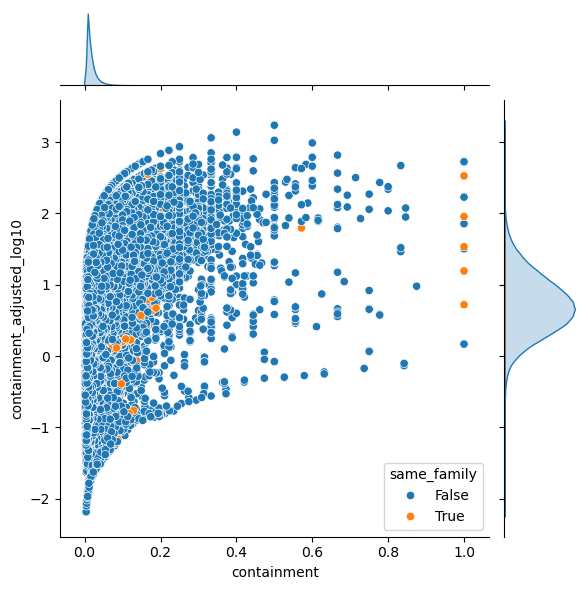

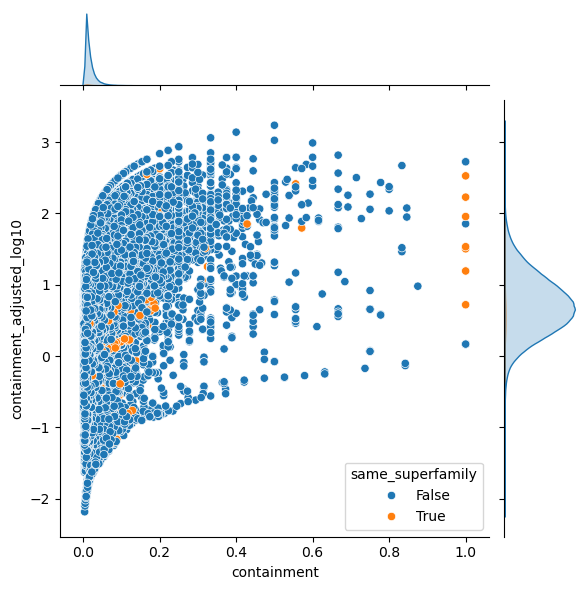

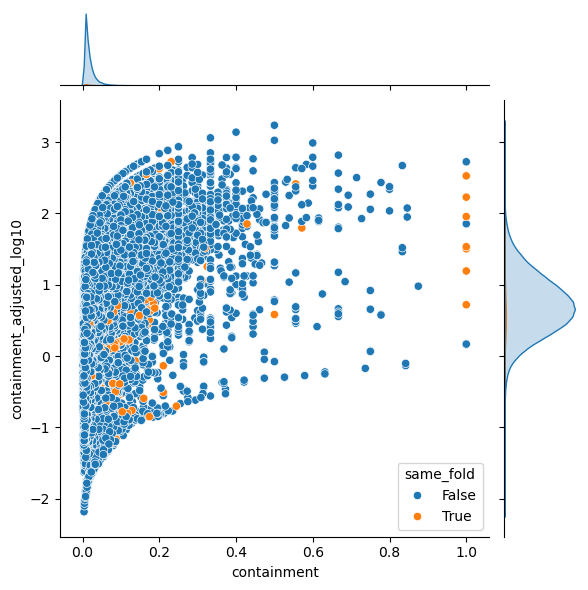

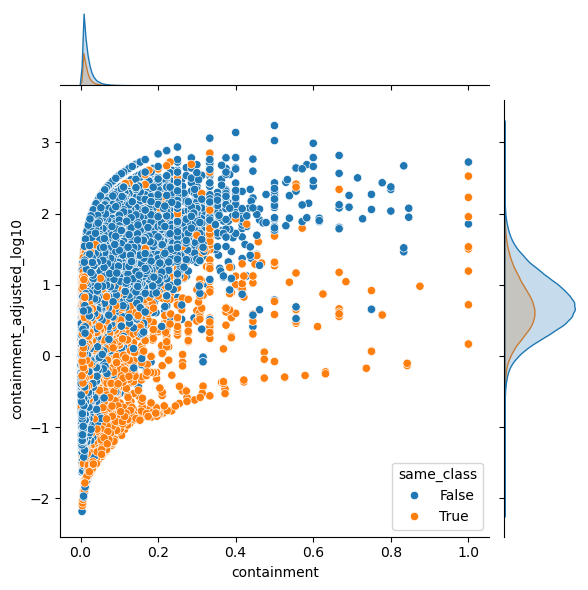

In [23]:
same_lineage_cols = [f"same_{x}" for x in lineage_cols]


for same_lineage in same_lineage_cols:
    sns.jointplot(
        multisearch, x="containment", y="containment_adjusted_log10", hue=same_lineage
    )

## I want to compare all the metrics for these different classes

In [24]:
sourmash_score_cols = (
    "containment",
    "tf_idf_score",
    "containment_adjusted_log10",
    "prob_overlap_adjusted",
)

In [34]:
multisearch.shape

(1761706, 32)

In [37]:
multisearch_melt_scop_levels = multisearch.melt(
    id_vars=["query_name", "match_name"],
    value_vars=same_lineage_cols,
    var_name="scop_level",
    value_name="is_same",
)
multisearch_melt_scop_levels["scop_level"] = (
    multisearch_melt_scop_levels["scop_level"].str.split("_").str[-1]
)
print(multisearch_melt_scop_levels.shape)
multisearch_melt_scop_levels.head()

(7046824, 4)


,query_name,match_name,scop_level,is_same
0,d2fcwa1 a.13.1.1 (A:216-320) alpha-2-Macroglob...,d4j42a_ a.25.3.0 (A:) automated matches {Bacil...,family,False
1,d6d5xa_ a.25.2.0 (A:) automated matches {Human...,d4j42a_ a.25.3.0 (A:) automated matches {Bacil...,family,False
2,d4dlla2 a.100.1.0 (A:191-316) automated matche...,d4j42a_ a.25.3.0 (A:) automated matches {Bacil...,family,False
3,d1n4ka1 a.118.22.1 (A:436-602) IP3 receptor ty...,d4j42a_ a.25.3.0 (A:) automated matches {Bacil...,family,False
4,d6s7ja_ a.127.1.0 (A:) automated matches {Trep...,d4j42a_ a.25.3.0 (A:) automated matches {Bacil...,family,False


In [40]:
value_cols = multisearch.columns[multisearch.dtypes == float]

multisearch_melt_sourmash_score = multisearch.melt(
    id_vars=["query_name", "match_name"],
    value_vars=value_cols,
    var_name="sourmash_score",
    value_name="score_value",
)
print(multisearch_melt_sourmash_score.shape)
multisearch_melt_sourmash_score.head()

(17617060, 4)


,query_name,match_name,sourmash_score,score_value
0,d2fcwa1 a.13.1.1 (A:216-320) alpha-2-Macroglob...,d4j42a_ a.25.3.0 (A:) automated matches {Bacil...,containment,0.034884
1,d6d5xa_ a.25.2.0 (A:) automated matches {Human...,d4j42a_ a.25.3.0 (A:) automated matches {Bacil...,containment,0.028169
2,d4dlla2 a.100.1.0 (A:191-316) automated matche...,d4j42a_ a.25.3.0 (A:) automated matches {Bacil...,containment,0.018692
3,d1n4ka1 a.118.22.1 (A:436-602) IP3 receptor ty...,d4j42a_ a.25.3.0 (A:) automated matches {Bacil...,containment,0.027027
4,d6s7ja_ a.127.1.0 (A:) automated matches {Trep...,d4j42a_ a.25.3.0 (A:) automated matches {Bacil...,containment,0.004184


In [ ]:
multisearch_melt_combined = multisearch_melt_sourmash_score.merge(
    multisearch_melt_scop_levels, on=["query_name", "match_name"]
)
print(multisearch_melt_combined.shape)
multisearch_melt_combined.head()

In [1]:
# sns.catplot(x="sourmash_score", y="value", hue="same_family", data=multisearch_melted)

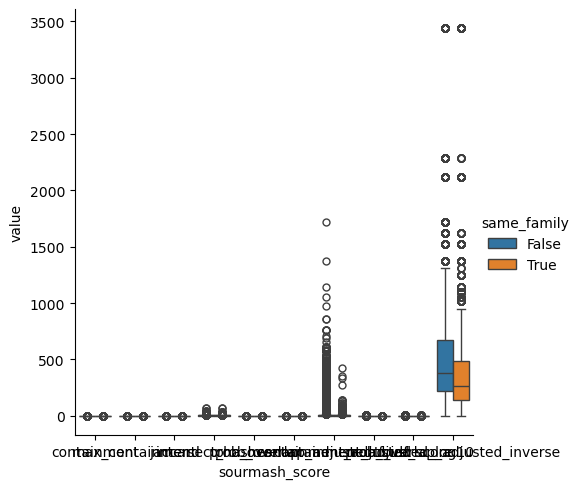

In [33]:
sns.catplot(
    y="sourmash_score",
    x="value",
    hue="same_family",
    data=multisearch_melted,
    kind="box",
)

In [138]:
for lineage_col in lineage_cols:
    query = f"query_{lineage_col}"
    match = f"match_{lineage_col}"

    multisearch[lineage_col] = multisearch[query] == multisearch[match]

# Ignore self matches
print(f"Before removing self-matches: {multisearch.shape}")
multisearch_no_self = multisearch.query("query_name != match_name")
print(f"After  removing self-matches: {multisearch_no_self.shape}")

Before removing self-matches: (236445, 35)
After  removing self-matches: (221276, 35)


In [139]:
# Ignore self matches
print(f"Before removing spurious matches: {multisearch_no_self.shape}")
multisearch_no_self_no_spurious = multisearch_no_self.query("intersect_hashes > 1")
print(f"After  removing spurious matches {multisearch_no_self_no_spurious.shape}")

Before removing spurious matches: (221276, 35)
After  removing spurious matches (111138, 35)


In [140]:
multisearch_no_self_no_spurious.dtypes

query_name                      object
query_md5                       object
match_name                      object
match_md5                       object
containment                    float64
max_containment                float64
jaccard                        float64
intersect_hashes               float64
prob_overlap                   float64
prob_overlap_adjusted          float64
containment_adjusted           float64
containment_adjusted_log10     float64
tf_idf_score                   float64
query_scop_id                   object
query_scop_lineage              object
query_scop_lineage_fixed        object
query_family                  category
query_superfamily             category
query_fold                    category
query_class                   category
match_scop_id                   object
match_scop_lineage              object
match_scop_lineage_fixed        object
match_family                  category
match_superfamily             category
match_fold               

### Create a multisearch table where self-matches and spurious matches (intersect hashes =1) are zeroed out

In [141]:
multisearch_zero_self_spurious = multisearch.copy()


self_matches = multisearch_zero_self_spurious.query("query_md5 == match_md5").index
spurious_matches = multisearch_zero_self_spurious.query("intersect_hashes == 1").index

multisearch_zero_self_spurious.loc[self_matches, sourmash_score_cols] = 0
# multisearch_zero_self_spurious.loc[spurious_matches, sourmash_score_cols] = 0

### Make query metadata

In [142]:
lineage_cols

['family', 'superfamily', 'fold', 'class']

In [143]:
query_scop_cols = [f"query_{x}" for x in lineage_cols]
match_scop_cols = [f"match_{x}" for x in lineage_cols]

same_scop_cols = [f"same_{x}" for x in lineage_cols]

# groupby = [, query_scop_cols]

In [144]:
query_metadata = pd.DataFrame(
    multisearch[query_scop_cols].values,
    index=multisearch["query_scop_id"].values,
    columns=query_scop_cols,
)
query_metadata = query_metadata.sort_index()
print(query_metadata.shape)
query_metadata = query_metadata.loc[~query_metadata.index.duplicated()]
print(query_metadata.shape)
query_metadata.head()

(236445, 4)
(15169, 4)


,query_family,query_superfamily,query_fold,query_class
d12asa_,d.104.1.1,d.104.1,d.104,d
d16vpa_,d.180.1.1,d.180.1,d.180,d
d1914a1,d.49.1.1,d.49.1,d.49,d
d1914a2,d.49.1.1,d.49.1,d.49,d
d1a04a1,a.4.6.2,a.4.6,a.4,a


### Compute pivot table to get `y_pred` for each class

In [145]:
query_vs_match_lineage_sourmash_score = multisearch_zero_self_spurious.pivot_table(
    index="query_scop_id",
    columns="match_class",
    values="containment_adjusted_log10",
    fill_value=0,
    aggfunc="max",
    dropna=False,
    observed=False,
)
query_vs_match_lineage_sourmash_score

match_class,a,b,c,d,e,f,g
query_scop_id,,,,,,,
d12asa_,1.333135,1.333135,1.333135,1.270083,0.000000,0.000000,0.0
d16vpa_,1.175465,1.293564,1.293564,1.293564,0.000000,1.293564,0.0
d1914a1,1.723463,0.000000,2.075646,2.075646,0.000000,0.000000,0.0
d1914a2,1.946777,1.946777,1.946777,1.946777,0.000000,1.946777,0.0
d1a04a1,0.000000,2.172556,2.172556,0.000000,2.172556,0.000000,0.0
...,...,...,...,...,...,...,...
g2dbx.1,1.100841,1.100841,1.100841,1.100841,1.100841,1.100841,0.0
g2vt1.1,0.000000,1.912918,1.912918,1.912918,0.000000,0.000000,0.0
g3bzy.1,1.923914,0.000000,1.923914,0.000000,0.000000,0.000000,0.0


In [146]:
query_vs_match_lineage_sourmash_score

match_class,a,b,c,d,e,f,g
query_scop_id,,,,,,,
d12asa_,1.333135,1.333135,1.333135,1.270083,0.000000,0.000000,0.0
d16vpa_,1.175465,1.293564,1.293564,1.293564,0.000000,1.293564,0.0
d1914a1,1.723463,0.000000,2.075646,2.075646,0.000000,0.000000,0.0
d1914a2,1.946777,1.946777,1.946777,1.946777,0.000000,1.946777,0.0
d1a04a1,0.000000,2.172556,2.172556,0.000000,2.172556,0.000000,0.0
...,...,...,...,...,...,...,...
g2dbx.1,1.100841,1.100841,1.100841,1.100841,1.100841,1.100841,0.0
g2vt1.1,0.000000,1.912918,1.912918,1.912918,0.000000,0.000000,0.0
g3bzy.1,1.923914,0.000000,1.923914,0.000000,0.000000,0.000000,0.0


In [147]:
y_pred = query_vs_match_lineage_sourmash_score.idxmax(axis=1).sort_index()
y_pred

query_scop_id
d12asa_    a
d16vpa_    b
d1914a1    c
d1914a2    a
d1a04a1    b
          ..
g2dbx.1    a
g2vt1.1    b
g3bzy.1    a
g3n55.1    a
g6rlx.1    a
Length: 15169, dtype: category
Categories (7, object): ['a' < 'b' < 'c' < 'd' < 'e' < 'f' < 'g']

In [148]:
# multisearch_no_self_no_spurious.pivot(index='query_name', values='query_class', columns='same_class')

In [149]:
y_true = pd.Series(
    index=multisearch_zero_self_spurious["query_scop_id"],
    data=multisearch_zero_self_spurious["query_class"].values,
)
y_true = y_true[~y_true.index.duplicated()].sort_index()
y_true

query_scop_id
d12asa_    d
d16vpa_    d
d1914a1    d
d1914a2    d
d1a04a1    a
          ..
g2dbx.1    d
g2vt1.1    d
g3bzy.1    d
g3n55.1    b
g6rlx.1    g
Length: 15169, dtype: category
Categories (7, object): ['a' < 'b' < 'c' < 'd' < 'e' < 'f' < 'g']

In [169]:
query_vs_match_lineage_sourmash_score.head()

match_class,a,b,c,d,e,f,g
query_scop_id,,,,,,,
d12asa_,1.333135,1.333135,1.333135,1.270083,0.000000,0.000000,0.0
d16vpa_,1.175465,1.293564,1.293564,1.293564,0.000000,1.293564,0.0
d1914a1,1.723463,0.000000,2.075646,2.075646,0.000000,0.000000,0.0
d1914a2,1.946777,1.946777,1.946777,1.946777,0.000000,1.946777,0.0
d1a04a1,0.000000,2.172556,2.172556,0.000000,2.172556,0.000000,0.0


In [170]:
# query_vs_match_lineage_sourmash_score.loc[y_true.index, y_true.values]

### containment_adjusted_log10 for the true family (ignoring self matches and single hashes): I think I want to plot this for different ksizes

In [171]:
y_score = query_vs_match_lineage_sourmash_score.apply(y_true, axis=1).sort_index()
y_score

d12asa_    1.270083
d16vpa_    1.293564
d1914a1    2.075646
d1914a2    1.946777
d1a04a1    0.000000
             ...   
g2dbx.1    1.100841
g2vt1.1    1.912918
g3bzy.1    0.000000
g3n55.1    1.833737
g6rlx.1    0.000000
Length: 15169, dtype: float64

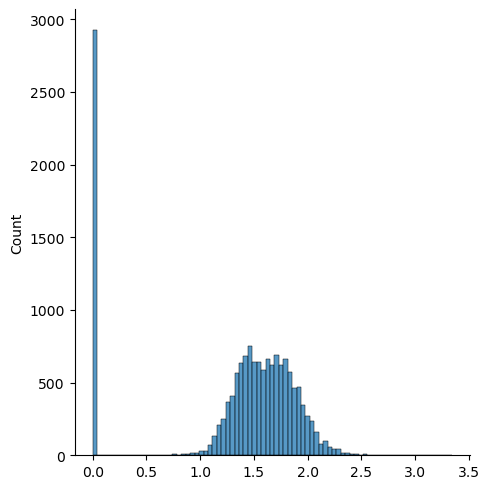

In [172]:
sns.displot(y_score)

In [173]:
precision_recall_fscore_support(y_true, y_pred)

(array([0.16974134, 0.27614321, 0.15502555, 0.23904382, 0.        ,
        0.37037037, 0.44444444]),
 array([0.65771558, 0.25490838, 0.06118333, 0.01642486, 0.        ,
        0.03012048, 0.01114206]),
 array([0.2698425 , 0.26510124, 0.08773903, 0.0307377 , 0.        ,
        0.05571031, 0.02173913]),
 array([2644, 3056, 4462, 3653,  304,  332,  718]))

In [174]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           a       0.17      0.66      0.27      2644
           b       0.28      0.25      0.27      3056
           c       0.16      0.06      0.09      4462
           d       0.24      0.02      0.03      3653
           e       0.00      0.00      0.00       304
           f       0.37      0.03      0.06       332
           g       0.44      0.01      0.02       718

    accuracy                           0.19     15169
   macro avg       0.24      0.15      0.10     15169
weighted avg       0.22      0.19      0.14     15169



In [175]:
query_metadata.head()

,query_family,query_superfamily,query_fold,query_class
d12asa_,d.104.1.1,d.104.1,d.104,d
d16vpa_,d.180.1.1,d.180.1,d.180,d
d1914a1,d.49.1.1,d.49.1,d.49,d
d1914a2,d.49.1.1,d.49.1,d.49,d
d1a04a1,a.4.6.2,a.4.6,a.4,a


In [176]:
query_metadata.shape

(15169, 4)

In [177]:
y_true.head()

query_scop_id
d12asa_    d
d16vpa_    d
d1914a1    d
d1914a2    d
d1a04a1    a
dtype: category
Categories (7, object): ['a' < 'b' < 'c' < 'd' < 'e' < 'f' < 'g']

In [178]:
y_true.shape

(15169,)

In [179]:
y_true.value_counts()

c    4462
d    3653
b    3056
a    2644
g     718
f     332
e     304
Name: count, dtype: int64

In [180]:
y_true_bool = y_true == query_metadata["query_class"]
y_true_bool.value_counts()

True    15169
Name: count, dtype: int64

In [181]:
# roc_auc_score(y_true_bool, y_score)

In [182]:
# RocCurveDisplay.from_predictions(y_true_bool, y_score)
# # d.plot()

In [183]:
# PrecisionRecallDisplay.from_predictions(y_true_bool, y_score)

In [184]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           a       0.17      0.66      0.27      2644
           b       0.28      0.25      0.27      3056
           c       0.16      0.06      0.09      4462
           d       0.24      0.02      0.03      3653
           e       0.00      0.00      0.00       304
           f       0.37      0.03      0.06       332
           g       0.44      0.01      0.02       718

    accuracy                           0.19     15169
   macro avg       0.24      0.15      0.10     15169
weighted avg       0.22      0.19      0.14     15169



In [185]:
# precision_recall_curve(y_true, y_score)

In [186]:
multisearch_no_self_no_spurious.head()

,query_name,query_md5,match_name,match_md5,containment,max_containment,jaccard,intersect_hashes,prob_overlap,prob_overlap_adjusted,containment_adjusted,containment_adjusted_log10,tf_idf_score,query_scop_id,query_scop_lineage,query_scop_lineage_fixed,query_family,query_superfamily,query_fold,query_class,match_scop_id,match_scop_lineage,match_scop_lineage_fixed,match_family,match_superfamily,match_fold,match_class,same_family,same_superfamily,same_fold,same_class,family,superfamily,fold,class
2,d2dita1 d.58.7.1 (A:8-106) HIV Tat-specific fa...,101ca324b2f0c3e29ad8f6e020339df3,d4j42a_ a.25.3.0 (A:) automated matches {Bacil...,2927928970a388981b12f1dba1be85b5,0.052632,0.070175,0.031008,4.0,2.652650e-12,0.000611,86.137974,1.935195,0.501526,d2dita1,d.58.7.1,d.58.7.1,d.58.7.1,d.58.7,d.58,d,d4j42a_,a.25.3.0,a.25.3.0,a.25.3.0,a.25.3,a.25,a,False,False,False,False,False,False,False,False
5,d1v5va2 d.250.1.1 (A:3-312) Glycine cleavage s...,f0227b386b4e8fe1535708eebe3b4bdc,d4j42a_ a.25.3.0 (A:) automated matches {Bacil...,2927928970a388981b12f1dba1be85b5,0.006969,0.035088,0.005848,2.0,1.326325e-12,0.000306,22.810056,1.358126,0.066404,d1v5va2,d.250.1.1,d.250.1.1,d.250.1.1,d.250.1,d.250,d,d4j42a_,a.25.3.0,a.25.3.0,a.25.3.0,a.25.3,a.25,a,False,False,False,False,False,False,False,False
6,d4cj9a_ a.298.1.1 (A:) BurrH {Burkholderia rhi...,fb393bfb4cab40b99294401548f50a00,d3gcea_ b.33.1.0 (A:) automated matches {Nocar...,6550c1f1f04d87d2f908386f437c61fb,0.003185,0.024691,0.002829,2.0,4.144765e-12,0.000955,3.335789,0.523199,0.017954,d4cj9a_,a.298.1.1,a.298.1.1,a.298.1.1,a.298.1,a.298,a,d3gcea_,b.33.1.0,b.33.1.0,b.33.1.0,b.33.1,b.33,b,False,False,False,False,False,False,False,False
7,"d1g0da3 b.1.5.1 (A:584-684) Transglutaminase, ...",77723abef0280214fd386a68077fde19,d3gcea_ b.33.1.0 (A:) automated matches {Nocar...,6550c1f1f04d87d2f908386f437c61fb,0.076923,0.076923,0.039216,6.0,9.284273e-12,0.002139,35.969703,1.555937,0.711697,d1g0da3,b.1.5.1,b.1.5.1,b.1.5.1,b.1.5,b.1,b,d3gcea_,b.33.1.0,b.33.1.0,b.33.1.0,b.33.1,b.33,b,False,False,False,True,False,False,False,True
12,d2q7sa1 c.56.5.9 (A:10-289) N-formylglutamate ...,377b5699a6db7fae5c77d9492e6becc9,d3gcea_ b.33.1.0 (A:) automated matches {Nocar...,6550c1f1f04d87d2f908386f437c61fb,0.011673,0.037037,0.008955,3.0,5.636880e-12,0.001298,8.990368,0.953777,0.107007,d2q7sa1,c.56.5.9,c.56.5.9,c.56.5.9,c.56.5,c.56,c,d3gcea_,b.33.1.0,b.33.1.0,b.33.1.0,b.33.1,b.33,b,False,False,False,False,False,False,False,False


In [187]:
lineage_nunique = multisearch[
    ["query_family", "query_superfamily", "query_fold", "query_class"]
].value_counts()
lineage_nunique

query_family  query_superfamily  query_fold  query_class
c.2.1.0       c.2.1              c.2         c              4627
c.94.1.0      c.94.1             c.94        c              3611
c.67.1.0      c.67.1             c.67        c              3525
a.104.1.0     a.104.1            a.104       a              2239
c.93.1.0      c.93.1             c.93        c              2219
                                                            ... 
a.30.4.1      a.30.4             a.30        a                 1
g.96.1.0      g.96.1             g.96        g                 1
g.41.11.0     g.41.11            g.41        g                 1
g.41.14.1     g.41.14            g.41        g                 1
g.41.7.1      g.41.7             g.41        g                 1
Name: count, Length: 4706, dtype: int64

In [188]:
multisearch_no_self[lineage_cols].sum()

family          2438
superfamily     4946
fold            6316
class          66310
dtype: int64

## Explore what ther Foldseek paper did with "class"

In [189]:
lineage_col = "class"

In [190]:
lineage_class_value_counts = multisearch["query_class"].value_counts()
lineage_class_value_counts

query_class
c    99676
d    46977
b    34598
a    33223
e    10354
f     9432
g     2185
Name: count, dtype: int64

In [205]:
foldseek_scop_rocx = pd.read_csv(
    "https://raw.githubusercontent.com/steineggerlab/foldseek-analysis/1737c718bfafd9f6ac300fb6a0ddde6330166202/multidomain_benchmark/PLOTS/FIG2/foldseek.rocx",
    sep="\t",
    index_col=0,
)
foldseek_scop_rocx = foldseek_scop_rocx.sort_index()
foldseek_scop_rocx

,SCOP,FAM,SFAM,FOLD,FP,FAMCNT,SFAMCNT,FOLDCNT
NAME,,,,,,,,
d1a04a1,a.4.6.2,1.000000,0.125000,0.012422,1,5,13,335
d1a04a2,c.23.1.1,1.000000,0.809524,0.038462,1,25,46,150
d1a0ca_,c.1.15.3,1.000000,1.000000,0.129834,1,2,11,373
d1a0ia1,b.40.4.6,0.833333,0.093750,0.000000,1,6,102,158
d1a0ia2,d.142.2.1,1.000000,1.000000,0.000000,1,3,8,30
...,...,...,...,...,...,...,...,...
d7fd1a_,d.58.1.2,0.666667,0.750000,0.003086,1,3,23,347
d7odca1,b.49.2.3,1.000000,0.333333,0.000000,1,4,7,15
d7odca2,c.1.6.1,1.000000,1.000000,0.049315,1,7,8,373


In [211]:
cols = [
    "query_name",
    "match_name",
    "query_family",
    "match_family",
    "intersect_hashes",
    "containment",
    "prob_overlap_adjusted",
    "containment_adjusted_log10",
    "tf_idf_score",
]

multisearch.query('query_scop_id == "d1a04a1" and intersect_hashes > 1')[cols]

,query_name,match_name,query_family,match_family,intersect_hashes,containment,prob_overlap_adjusted,containment_adjusted_log10,tf_idf_score
4273,d1a04a1 a.4.6.2 (A:150-216) Nitrate/nitrite re...,d1a04a1 a.4.6.2 (A:150-216) Nitrate/nitrite re...,a.4.6.2,a.4.6.2,44.0,1.000000,0.003131,2.504254,9.826551
87608,d1a04a1 a.4.6.2 (A:150-216) Nitrate/nitrite re...,d3ivma1 b.69.7.0 (A:7-417) automated matches {...,a.4.6.2,b.69.7.0,2.0,0.045455,0.000306,2.172556,0.433136
90292,d1a04a1 a.4.6.2 (A:150-216) Nitrate/nitrite re...,d6tl8a_ c.10.2.0 (A:) automated matches {Mouse...,a.4.6.2,c.10.2.0,2.0,0.045455,0.000496,1.961702,0.426598
98149,d1a04a1 a.4.6.2 (A:150-216) Nitrate/nitrite re...,d6tpla1 b.1.14.1 (A:555-657) Intimin {Escheric...,a.4.6.2,b.1.14.1,2.0,0.045455,0.000306,2.172556,0.433136
220174,d1a04a1 a.4.6.2 (A:150-216) Nitrate/nitrite re...,"d1d3ya_ e.12.1.1 (A:) DNA topoisomerase IV, al...",a.4.6.2,e.12.1.1,3.0,0.068182,0.000458,2.172556,0.649704


In [213]:
cols = [
    "query_name",
    "match_name",
    "query_family",
    "match_family",
    "intersect_hashes",
    "containment",
    "prob_overlap_adjusted",
    "containment_adjusted_log10",
    "tf_idf_score",
]

multisearch.query('query_scop_id == "d1ty4a_" and intersect_hashes > 1')[cols]

,query_name,match_name,query_family,match_family,intersect_hashes,containment,prob_overlap_adjusted,containment_adjusted_log10,tf_idf_score


In [215]:
bcl2_inhibitors_programmed_cell_death = "f.1.4.1"
multisearch.query(
    "query_family == @bcl2_inhibitors_programmed_cell_death and intersect_hashes > 1 and containment < 1"
)

,query_name,query_md5,match_name,match_md5,containment,max_containment,jaccard,intersect_hashes,prob_overlap,prob_overlap_adjusted,containment_adjusted,containment_adjusted_log10,tf_idf_score,query_scop_id,query_scop_lineage,query_scop_lineage_fixed,query_family,query_superfamily,query_fold,query_class,match_scop_id,match_scop_lineage,match_scop_lineage_fixed,match_family,match_superfamily,match_fold,match_class,same_family,same_superfamily,same_fold,same_class,family,superfamily,fold,class
7574,d1ohua_ f.1.4.1 (A:) Apoptosis regulator ced-9...,a1140d1a054f3e3f9d084d6a290a54dd,d2cbza1 c.37.1.0 (A:642-871) automated matches...,2236a5ec50d5c4fed2c6fabc7442c82a,0.020134,0.020134,0.008499,3.0,1.989487e-12,0.000458,43.936148,1.642822,0.191859,d1ohua_,f.1.4.1,f.1.4.1,f.1.4.1,f.1.4,f.1,f,d2cbza1,c.37.1.0,c.37.1.0,c.37.1.0,c.37.1,c.37,c,False,False,False,False,False,False,False,False
13169,d7jgwa1 f.1.4.1 (A:1-196) Apoptosis regulator ...,cd785d034250181e61281b8ab64798cc,d2ff4a2 a.118.8.3 (A:105-283) Probable regulat...,cbda0bce5eb5c9c9c03f5fbfe6d22929,0.017094,0.017094,0.007380,2.0,1.326325e-12,0.000306,55.952872,1.747822,0.162889,d7jgwa1,f.1.4.1,f.1.4.1,f.1.4.1,f.1.4,f.1,f,d2ff4a2,a.118.8.3,a.118.8.3,a.118.8.3,a.118.8,a.118,a,False,False,False,False,False,False,False,False
22102,d1ddba_ f.1.4.1 (A:) Proapoptotic molecule Bid...,4070fb9426d56583b18c2bd51655b521,d1g4wr2 c.45.1.2 (R:297-539) SptP tyrosine pho...,28b5b7a0f8306ebbf4c21bc1ff056829,0.017442,0.017442,0.007712,3.0,1.989487e-12,0.000458,38.060965,1.580480,0.166203,d1ddba_,f.1.4.1,f.1.4.1,f.1.4.1,f.1.4,f.1,f,d1g4wr2,c.45.1.2,c.45.1.2,c.45.1.2,c.45.1,c.45,c,False,False,False,False,False,False,False,False
25945,d7jgwa1 f.1.4.1 (A:1-196) Apoptosis regulator ...,cd785d034250181e61281b8ab64798cc,d6hn1a2 a.126.1.0 (A:196-387) automated matche...,9d64ab94bbaac3374b4738dc7b8e444f,0.017094,0.017094,0.007042,2.0,1.326325e-12,0.000306,55.952872,1.747822,0.162889,d7jgwa1,f.1.4.1,f.1.4.1,f.1.4.1,f.1.4,f.1,f,d6hn1a2,a.126.1.0,a.126.1.0,a.126.1.0,a.126.1,a.126,a,False,False,False,False,False,False,False,False
31578,d6udva_ f.1.4.1 (A:) EAT/MCL-1 (Myeloid cell l...,f26dcf3500caefeb5a29a6cf17aa86da,d5lhfa_ c.1.2.0 (A:) automated matches {Thermo...,10ebf71efd24a33dc95526f1f16c7820,0.015152,0.015152,0.006349,2.0,1.326325e-12,0.000306,49.594591,1.695434,0.144379,d6udva_,f.1.4.1,f.1.4.1,f.1.4.1,f.1.4,f.1,f,d5lhfa_,c.1.2.0,c.1.2.0,c.1.2.0,c.1.2,c.1,c,False,False,False,False,False,False,False,False
35162,d1ddba_ f.1.4.1 (A:) Proapoptotic molecule Bid...,4070fb9426d56583b18c2bd51655b521,d1rp3b_ a.137.11.1 (B:) Anti-sigma factor FlgM...,da6361abc3ab34a4c70d47507ae1450c,0.017442,0.046875,0.012876,3.0,3.647393e-12,0.000840,20.760526,1.317238,0.162858,d1ddba_,f.1.4.1,f.1.4.1,f.1.4.1,f.1.4,f.1,f,d1rp3b_,a.137.11.1,a.137.11.1,a.137.11.1,a.137.11,a.137,a,False,False,False,False,False,False,False,False
46054,d1ddba_ f.1.4.1 (A:) Proapoptotic molecule Bid...,4070fb9426d56583b18c2bd51655b521,d2z16a1 a.95.1.1 (A:2-158) automated matches {...,36e9c9541b4b8a152f4a8381a9dbff0d,0.023256,0.029851,0.013245,4.0,2.652650e-12,0.000611,38.060965,1.580480,0.221604,d1ddba_,f.1.4.1,f.1.4.1,f.1.4.1,f.1.4,f.1,f,d2z16a1,a.95.1.1,a.95.1.1,a.95.1.1,a.95.1,a.95,a,False,False,False,False,False,False,False,False
56696,d1ddba_ f.1.4.1 (A:) Proapoptotic molecule Bid...,4070fb9426d56583b18c2bd51655b521,d1xoua_ a.231.1.1 (A:) Secreted protein EspA {...,2ce1011e19790d12eec9a73bb4823238,0.011628,0.014599,0.006515,2.0,1.326325e-12,0.000306,38.060965,1.580480,0.110802,d1ddba_,f.1.4.1,f.1.4.1,f.1.4.1,f.1.4,f.1,f,d1xoua_,a.231.1.1,a.231.1.1,a.231.1.1,a.231.1,a.231,a,False,False,False,False,False,False,False,False
57041,d1ohua_ f.1.4.1 (A:) Apoptosis regulator ced-9...,a1140d1a054f3e3f9d084d6a290a54dd,d1dl2a_ a.102.2.1 (A:) Class I alpha-1;2-manno...,7222911dca54f82eeaef9605aa5ceeae,0.020134,0.020134,0.004732,3.0,4.476346e-12,0.001031,19.527177,1.290639,0.186067,d1ohua_,f.1.4.1,f.1.4.1,f.1.4.1,f.1.4,f.1,f,d1dl2a_,a.102.2.1,a.102.2.1,a.102.2.1

In [192]:
foldseek_scop_rocx.query("FP < 1")

,SCOP,FAM,SFAM,FOLD,FP,FAMCNT,SFAMCNT,FOLDCNT
NAME,,,,,,,,
d2ciob_,b.1.26.0,0.0,0.0,0.0,0,1,3,402


In [193]:
multisearch_no_self.head()

,query_name,query_md5,match_name,match_md5,containment,max_containment,jaccard,intersect_hashes,prob_overlap,prob_overlap_adjusted,containment_adjusted,containment_adjusted_log10,tf_idf_score,query_scop_id,query_scop_lineage,query_scop_lineage_fixed,query_family,query_superfamily,query_fold,query_class,match_scop_id,match_scop_lineage,match_scop_lineage_fixed,match_family,match_superfamily,match_fold,match_class,same_family,same_superfamily,same_fold,same_class,family,superfamily,fold,class
1,d2q4gw_ c.10.1.1 (W:) automated matches {Human...,896c4441aae821222649f6c1f64eecd7,d4j42a_ a.25.3.0 (A:) automated matches {Bacil...,2927928970a388981b12f1dba1be85b5,0.002288,0.017544,0.002028,1.0,6.631624e-13,0.000153,14.980517,1.175527,0.021805,d2q4gw_,c.10.1.1,c.10.1.1,c.10.1.1,c.10.1,c.10,c,d4j42a_,a.25.3.0,a.25.3.0,a.25.3.0,a.25.3,a.25,a,False,False,False,False,False,False,False,False
2,d2dita1 d.58.7.1 (A:8-106) HIV Tat-specific fa...,101ca324b2f0c3e29ad8f6e020339df3,d4j42a_ a.25.3.0 (A:) automated matches {Bacil...,2927928970a388981b12f1dba1be85b5,0.052632,0.070175,0.031008,4.0,2.652650e-12,0.000611,86.137974,1.935195,0.501526,d2dita1,d.58.7.1,d.58.7.1,d.58.7.1,d.58.7,d.58,d,d4j42a_,a.25.3.0,a.25.3.0,a.25.3.0,a.25.3,a.25,a,False,False,False,False,False,False,False,False
3,d4xmra1 d.110.6.4 (A:41-285) Cj1564 {Campyloba...,80b412d0452551ff3286100baacfa109,d4j42a_ a.25.3.0 (A:) automated matches {Bacil...,2927928970a388981b12f1dba1be85b5,0.004505,0.017544,0.003597,1.0,6.631624e-13,0.000153,29.488676,1.469655,0.042923,d4xmra1,d.110.6.4,d.110.6.4,d.110.6.4,d.110.6,d.110,d,d4j42a_,a.25.3.0,a.25.3.0,a.25.3.0,a.25.3,a.25,a,False,False,False,False,False,False,False,False
4,d1m1jb1 d.171.1.1 (B:200-464) Fibrinogen C-ter...,0072d84134578f4b85fdc79718d81ed0,d4j42a_ a.25.3.0 (A:) automated matches {Bacil...,2927928970a388981b12f1dba1be85b5,0.004132,0.017544,0.003356,1.0,6.631624e-13,0.000153,27.051595,1.432193,0.039376,d1m1jb1,d.171.1.1,d.171.1.1,d.171.1.1,d.171.1,d.171,d,d4j42a_,a.25.3.0,a.25.3.0,a.25.3.0,a.25.3,a.25,a,False,False,False,False,False,False,False,False
5,d1v5va2 d.250.1.1 (A:3-312) Glycine cleavage s...,f0227b386b4e8fe1535708eebe3b4bdc,d4j42a_ a.25.3.0 (A:) automated matches {Bacil...,2927928970a388981b12f1dba1be85b5,0.006969,0.035088,0.005848,2.0,1.326325e-12,0.000306,22.810056,1.358126,0.066404,d1v5va2,d.250.1.1,d.250.1.1,d.250.1.1,d.250.1,d.250,d,d4j42a_,a.25.3.0,a.25.3.0,a.25.3.0,a.25.3,a.25,a,False,False,False,False,False,False,False,False


In [194]:
# (
#     multisearch_zero_self_spurious.groupby(["query_scop_id", "query_family"])[
#         same_scop_cols
#     ].sum()
#     - 1
# )

In [195]:
same_scop_counts = multisearch_zero_self_spurious.groupby(
    ["query_scop_id"] + query_scop_cols, observed=True
)[same_scop_cols].sum()

# Subtract 1 for self-matches
# Doing this after the fact makes sure that we have ALL 15,177 samples for
# each analyses, otherwise they'd be unobserved
same_scop_counts -= 1

same_scop_bool = same_scop_counts > 0
same_scop_bool.columns = same_scop_bool.columns + "_bool"
same_scop_counts = pd.concat([same_scop_counts, same_scop_bool], axis=1)
same_scop_counts.head()

,,,,,same_family,same_superfamily,same_fold,same_class,same_family_bool,same_superfamily_bool,same_fold_bool,same_class_bool
query_scop_id,query_family,query_superfamily,query_fold,query_class,,,,,,,,
d12asa_,d.104.1.1,d.104.1,d.104,d,0,0,0,4,False,False,False,True
d16vpa_,d.180.1.1,d.180.1,d.180,d,0,0,0,7,False,False,False,True
d1914a1,d.49.1.1,d.49.1,d.49,d,0,0,0,1,False,False,False,True
d1914a2,d.49.1.1,d.49.1,d.49,d,0,1,1,1,False,True,True,True
d1a04a1,a.4.6.2,a.4.6,a.4,a,0,0,0,0,False,False,False,False


In [196]:
same_scop_counts_reset = same_scop_counts.reset_index(level=[1, 2, 3, 4])
same_scop_counts_reset.head()

,query_family,query_superfamily,query_fold,query_class,same_family,same_superfamily,same_fold,same_class,same_family_bool,same_superfamily_bool,same_fold_bool,same_class_bool
query_scop_id,,,,,,,,,,,,
d12asa_,d.104.1.1,d.104.1,d.104,d,0,0,0,4,False,False,False,True
d16vpa_,d.180.1.1,d.180.1,d.180,d,0,0,0,7,False,False,False,True
d1914a1,d.49.1.1,d.49.1,d.49,d,0,0,0,1,False,False,False,True
d1914a2,d.49.1.1,d.49.1,d.49,d,0,1,1,1,False,True,True,True
d1a04a1,a.4.6.2,a.4.6,a.4,a,0,0,0,0,False,False,False,False


In [197]:
# same_scop_counts[same_scop_cols].value_counts()

In [198]:
def count_scop_lineage(df, col):
    return Counter([df[col].cat.categories[i] for i in df[col].cat.codes])


n_groups_per_scop_lineage = {
    lineage: count_scop_lineage(multisearch_no_self, f"query_{lineage}")
    for lineage in lineage_cols
}
n_groups_per_scop_lineage.keys()
# n_groups_per_scop_lineage

dict_keys(['family', 'superfamily', 'fold', 'class'])

In [199]:
def get_sensitivity_per_scop_lineage(
    row, n_groups_per_scop_lineage=n_groups_per_scop_lineage
):
    percentages = {}
    for lineage, counts in n_groups_per_scop_lineage.items():
        ql = f"query_{lineage}"
        divisor = counts[row[ql]] - 1
        if divisor > 0:
            percentage = row[f"same_{lineage}"] / divisor
        else:
            percentage = 0
        percentages[lineage] = percentage
    return pd.Series(percentages)


same_scop_sensitivity = same_scop_counts_reset.apply(
    get_sensitivity_per_scop_lineage, axis=1
)
# same_scop_sensitivity.columns = "same_" + same_scop_percentage.columns + "_sensitivity"
same_scop_sensitivity

,family,superfamily,fold,class
query_scop_id,,,,
d12asa_,0.0,0.00,0.00,0.000092
d16vpa_,0.0,0.00,0.00,0.000162
d1914a1,0.0,0.00,0.00,0.000023
d1914a2,0.0,0.05,0.05,0.000023
d1a04a1,0.0,0.00,0.00,0.000000
...,...,...,...,...
g2dbx.1,0.0,0.00,0.00,0.000277
g2vt1.1,0.0,0.00,0.00,0.000046
g3bzy.1,0.0,0.00,0.00,0.000000


In [204]:
same_scop_sensitivity.max()

family         0.200000
superfamily    0.125000
fold           0.100000
class          0.006374
dtype: float64

In [200]:
import matplotlib.pyplot as plt

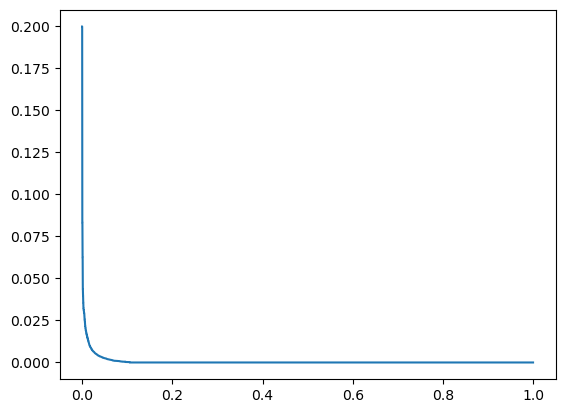

In [201]:
fraction_queries = pd.Series(
    np.linspace(0, 1, num=len(same_scop_sensitivity)), name="fraction_queries"
)

plt.plot(fraction_queries, same_scop_sensitivity["family"].sort_values(ascending=False))

In [202]:
same_scop_combined = pd.concat(
    [
        same_scop_counts_reset,
        same_scop_sensitivity,
    ],
    axis=1,
)
same_scop_combined.head()

,query_family,query_superfamily,query_fold,query_class,same_family,same_superfamily,same_fold,same_class,same_family_bool,same_superfamily_bool,same_fold_bool,same_class_bool,family,superfamily,fold,class
query_scop_id,,,,,,,,,,,,,,,,
d12asa_,d.104.1.1,d.104.1,d.104,d,0,0,0,4,False,False,False,True,0.0,0.00,0.00,0.000092
d16vpa_,d.180.1.1,d.180.1,d.180,d,0,0,0,7,False,False,False,True,0.0,0.00,0.00,0.000162
d1914a1,d.49.1.1,d.49.1,d.49,d,0,0,0,1,False,False,False,True,0.0,0.00,0.00,0.000023
d1914a2,d.49.1.1,d.49.1,d.49,d,0,1,1,1,False,True,True,True,0.0,0.05,0.05,0.000023
d1a04a1,a.4.6.2,a.4.6,a.4,a,0,0,0,0,False,False,False,False,0.0,0.00,0.00,0.000000


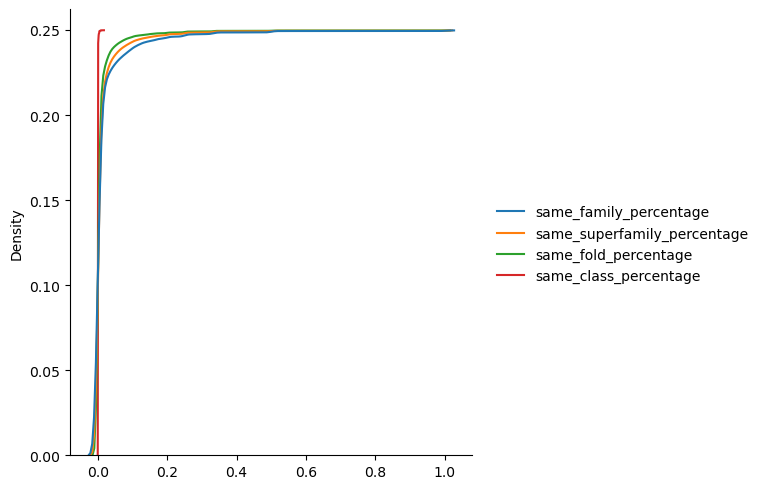

In [203]:
sns.displot(same_scop_percentage, cumulative=True, kind="kde")

In [243]:
# %debug

In [244]:
# def get_percentage_found(

# true_positive_rate = multisearch_no_self.groupby("query_class").apply(
#     lambda x: x["class"].sum() / lineage_class_value_counts[x.name]
# )
# true_positive_rate

In [ ]:
# false_positive_rate = multisearch_no_self.groupby("query_class").apply(
#     lambda x: x["class"].sum() / lineage_class_value_counts[x.name]
# )
# false_positive_rate

In [118]:
multisearch_no_self["class"].value_counts()

class
True     20644
False    17832
Name: count, dtype: int64

### Show Example Classification Report

In [122]:
y_true = multisearch_no_self["query_class"]
y_pred = multisearch_no_self["match_class"]
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    multilabel_confusion_matrix,
    precision_recall_fscore_support,
)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           a       0.35      0.35      0.35      5091
           b       0.41      0.41      0.41      4574
           c       0.68      0.68      0.68     19011
           d       0.45      0.45      0.45      7356
           e       0.29      0.29      0.29      1472
           f       0.20      0.20      0.20       741
           g       0.35      0.35      0.35       231

    accuracy                           0.54     38476
   macro avg       0.39      0.39      0.39     38476
weighted avg       0.54      0.54      0.54     38476



(array([0.34727951, 0.41407958, 0.68339382, 0.45323545, 0.28940217,
        0.20242915, 0.34632035]),
 array([0.34727951, 0.41407958, 0.68339382, 0.45323545, 0.28940217,
        0.20242915, 0.34632035]),
 array([0.34727951, 0.41407958, 0.68339382, 0.45323545, 0.28940217,
        0.20242915, 0.34632035]),
 array([ 5091,  4574, 19011,  7356,  1472,   741,   231]))

In [164]:
# classification_report??

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [17]:
precision, recall, thresholds = precision_recall_curve(
    multisearch_no_self["class"], multisearch_no_self.containment
)

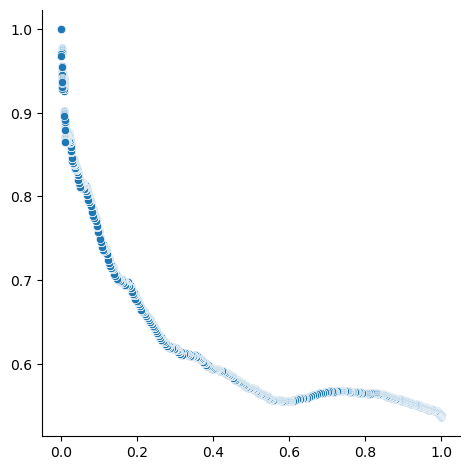

In [18]:
sns.relplot(x=recall, y=precision)

### PrecisionRecallDisplay

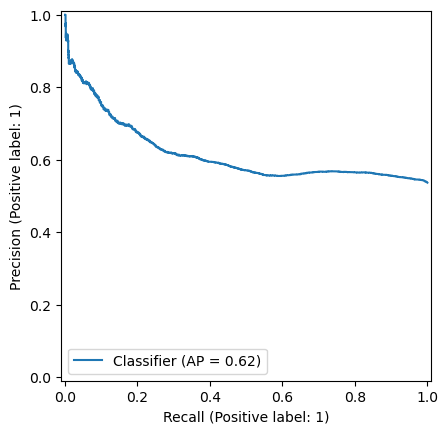

In [19]:
PrecisionRecallDisplay.from_predictions(
    multisearch_no_self["class"], multisearch_no_self.containment
)

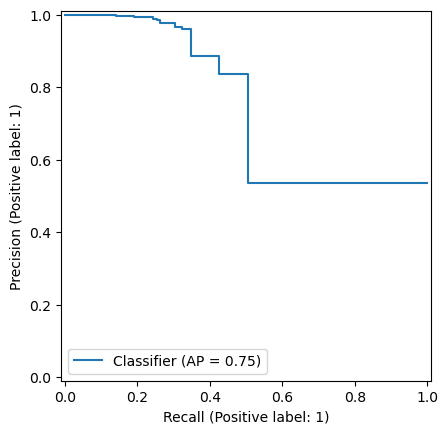

In [20]:
PrecisionRecallDisplay.from_predictions(
    multisearch_no_self["class"], multisearch_no_self.prob_overlap_adjusted
)

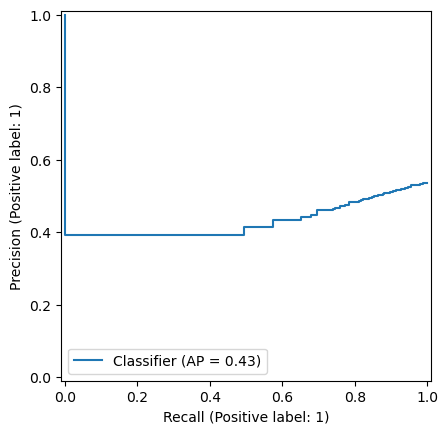

In [21]:
PrecisionRecallDisplay.from_predictions(
    multisearch_no_self["class"], 1 / multisearch_no_self.prob_overlap_adjusted
)

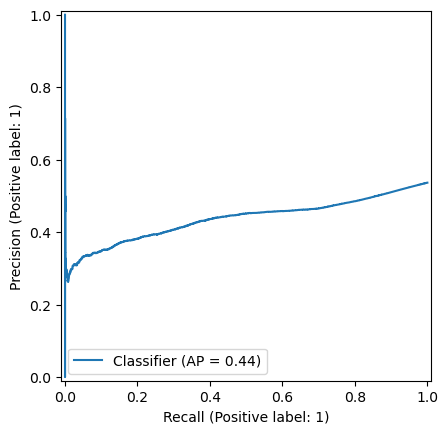

In [22]:
PrecisionRecallDisplay.from_predictions(
    multisearch_no_self["class"], multisearch_no_self.containment_adjusted_log10
)

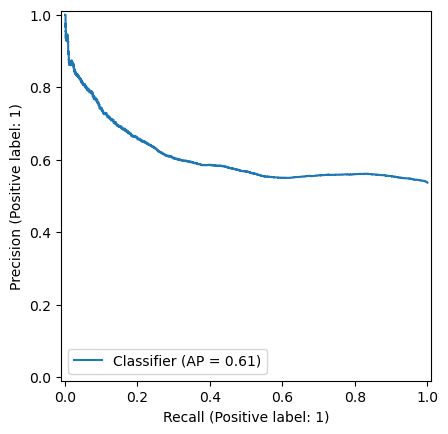

In [23]:
PrecisionRecallDisplay.from_predictions(
    multisearch_no_self["class"], multisearch_no_self.tf_idf_score
)

### RocCurveDisplay

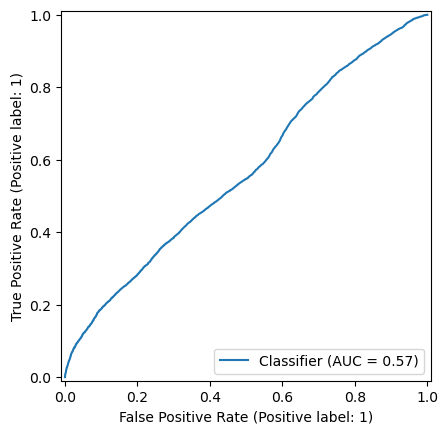

In [24]:
RocCurveDisplay.from_predictions(
    multisearch_no_self["class"], multisearch_no_self.containment
)

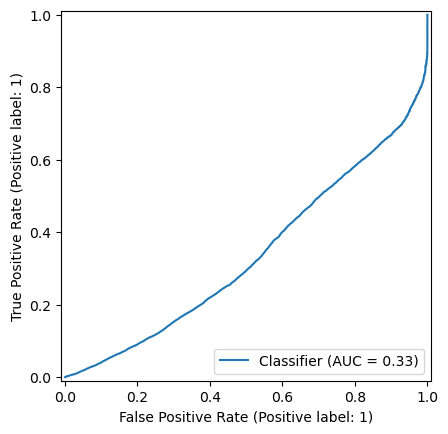

In [25]:
RocCurveDisplay.from_predictions(
    multisearch_no_self["class"], multisearch_no_self.containment_adjusted_log10
)

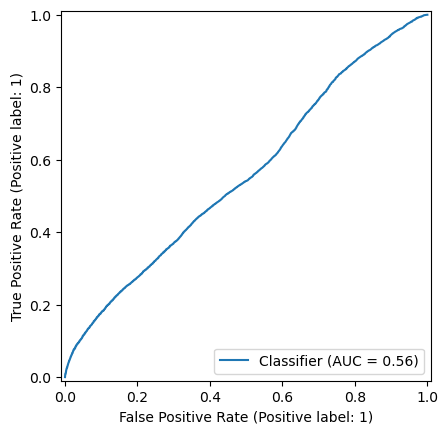

In [26]:
RocCurveDisplay.from_predictions(
    multisearch_no_self["class"], multisearch_no_self.tf_idf_score
)

### DetCurveDisplay

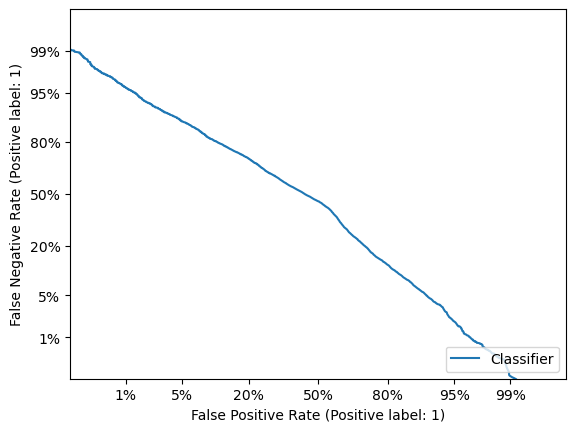

In [27]:
DetCurveDisplay.from_predictions(
    multisearch_no_self["class"], multisearch_no_self.containment
)

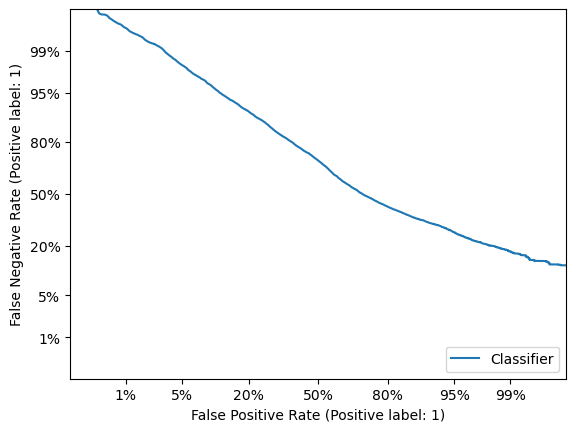

In [28]:
DetCurveDisplay.from_predictions(
    multisearch_no_self["class"], multisearch_no_self.containment_adjusted_log10
)

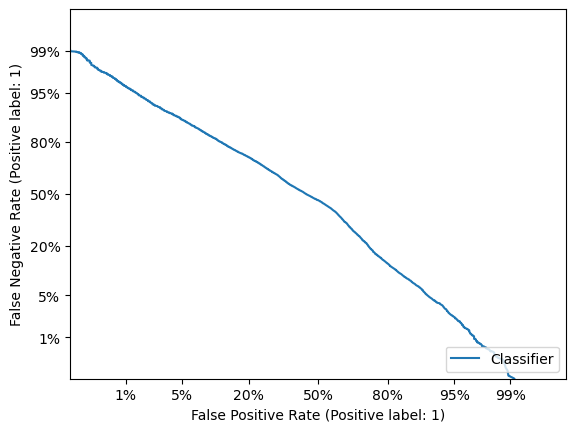

In [29]:
DetCurveDisplay.from_predictions(
    multisearch_no_self["class"], multisearch_no_self.tf_idf_score
)

## Compute precision-recall, ROC, DET curves

In [56]:
from typing import Literal

score_cols = (
    "containment",
    "tf_idf_score",
    "containment_adjusted_log10",
    "prob_overlap_adjusted",
)

dfs = []


def make_precision_recall_curve_df(y_true, y_score):
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    # Add a dummy value to thresholds so all the arrays are the same length
    thresholds = np.concat([thresholds, [thresholds.max()]])
    df = pd.DataFrame(dict(precision=precision, recall=recall, thresholds=thresholds))
    return df


def make_roc_curve_df(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    df = pd.DataFrame(dict(fpr=fpr, tpr=tpr, thresholds=thresholds))
    return df


def make_det_curve_df(y_true, y_score):
    fpr, fnr, thresholds = det_curve(y_true, y_score)
    df = pd.DataFrame(dict(fpr=fpr, fnr=fnr, thresholds=thresholds))
    return df


curve_df_makers = {
    "precision_recall": make_precision_recall_curve_df,
    "roc": make_roc_curve_df,
    "det": make_det_curve_df,
}


def make_curve_df(
    y_true,
    y_score,
    lineage,
    score_name,
    curve: Literal["precision_recall", "roc", "det"],
):
    df_maker = curve_df_makers[curve]
    df = df_maker(y_true, y_score)
    df["lineage"] = lineage_col
    df["score_name"] = score_col
    return df


curve_dfs = {
    "precision_recall": [],
    "roc": [],
    "det": [],
}

lines = []


for lineage_col in lineage_cols:
    for score_col in score_cols:
        y_true = multisearch_no_self[lineage_col]
        # y_true = multisearch_no_self[lineage_col]
        y_score = multisearch_no_self[score_col]

        ap_score = average_precision_score(y_true, y_score)
        roc_score = roc_auc_score(y_true, y_score)

        lines.append([lineage_col, score_col, ap_score, "average_precision"])
        lines.append([lineage_col, score_col, roc_score, "roc"])

        for curve in curve_df_makers.keys():
            df = make_curve_df(y_true, y_score, lineage_col, score_col, curve)

            curve_dfs[curve].append(df)
classification_metrics = pd.DataFrame(
    lines, columns=["lineage", "sourmash_score", "metric", "metric_name"]
)
classification_metrics

,lineage,sourmash_score,metric,metric_name
0,family,containment,0.311685,average_precision
1,family,containment,0.631559,roc
2,family,tf_idf_score,0.303030,average_precision
3,family,tf_idf_score,0.618050,roc
4,family,containment_adjusted_log10,0.132928,average_precision
5,family,containment_adjusted_log10,0.300670,roc
6,family,prob_overlap_adjusted,0.459467,average_precision
7,family,prob_overlap_adjusted,0.787603,roc
8,superfamily,containment,0.507712,average_precision
9,superfamily,containment,0.652650,roc


### Show Example Classification Report

In [102]:
y_true = multisearch_no_self["query_class"]
y_pred = multisearch_no_self["match_class"]
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    multilabel_confusion_matrix,
)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           a       1.00      1.00      1.00        10
           b       1.00      1.00      1.00         8
           c       1.00      1.00      1.00         8
           d       1.00      1.00      1.00         2
           e       1.00      1.00      1.00         2
           g       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



### Show Confusion Matrix

In [103]:
confusion_matrix(y_true, y_pred)

array([[10,  0,  0,  0,  0,  0],
       [ 0,  8,  0,  0,  0,  0],
       [ 0,  0,  8,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  0],
       [ 0,  0,  0,  0,  2,  0],
       [ 0,  0,  0,  0,  0,  2]])

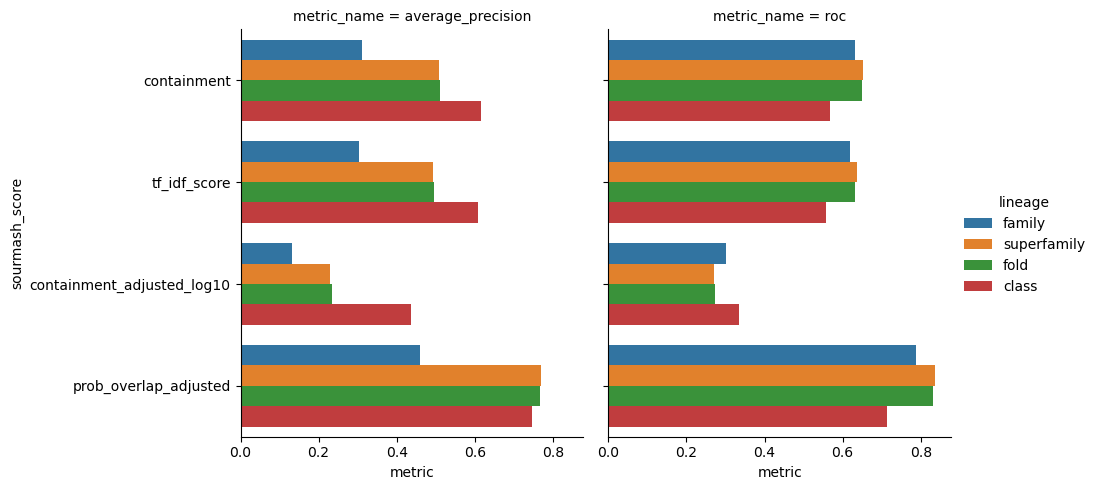

In [66]:
sns.catplot(
    data=classification_metrics,
    x="metric",
    hue="lineage",
    y="sourmash_score",
    col="metric_name",
    kind="bar",
    # palette="Set2",
)

In [41]:
len(curve_dfs["precision_recall"])

16

In [42]:
precision_recall_df = pd.concat(curve_dfs["precision_recall"])
print(precision_recall_df.shape)
precision_recall_df.head()

(45524, 5)


,precision,recall,thresholds,lineage,score_name
0,0.190145,1.000000,0.000603,family,containment
1,0.190188,0.999863,0.000669,family,containment
2,0.190290,0.999727,0.000693,family,containment
3,0.190350,0.999727,0.000795,family,containment
4,0.190370,0.999727,0.000833,family,containment


In [43]:
det_df = pd.concat(curve_dfs["det"])
print(det_df.shape)
det_df.head()

(44706, 5)


,fpr,fnr,thresholds,lineage,score_name
0,1.000000,0.000000,0.000603,family,containment
1,0.999583,0.000137,0.000669,family,containment
2,0.998780,0.000273,0.000693,family,containment
3,0.998395,0.000273,0.000795,family,containment
4,0.998267,0.000273,0.000833,family,containment


In [44]:
roc_df = pd.concat(curve_dfs["roc"])
print(roc_df.shape)
roc_df.head()

(35302, 5)


,fpr,tpr,thresholds,lineage,score_name
0,0.000000,0.000000,inf,family,containment
1,0.000064,0.000410,1.000000,family,containment
2,0.000064,0.000683,0.833333,family,containment
3,0.000096,0.000683,0.818182,family,containment
4,0.000096,0.001914,0.170543,family,containment


## Plot curves across SCOP lineages and sourmash match scores (containment, tf-idf score, adjusted containment, probability of overlap)

### Plot Precision Recall

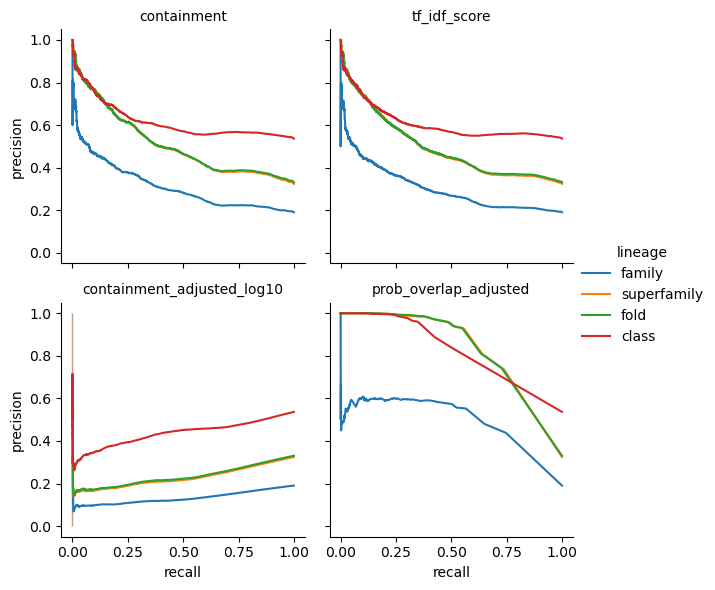

In [68]:
g = sns.relplot(
    data=precision_recall_df,
    x="recall",
    y="precision",
    hue="lineage",
    col="score_name",
    height=3,
    col_wrap=2,
    kind="line",
)
g.set_titles("{col_name}")

### Plot ROC AUC

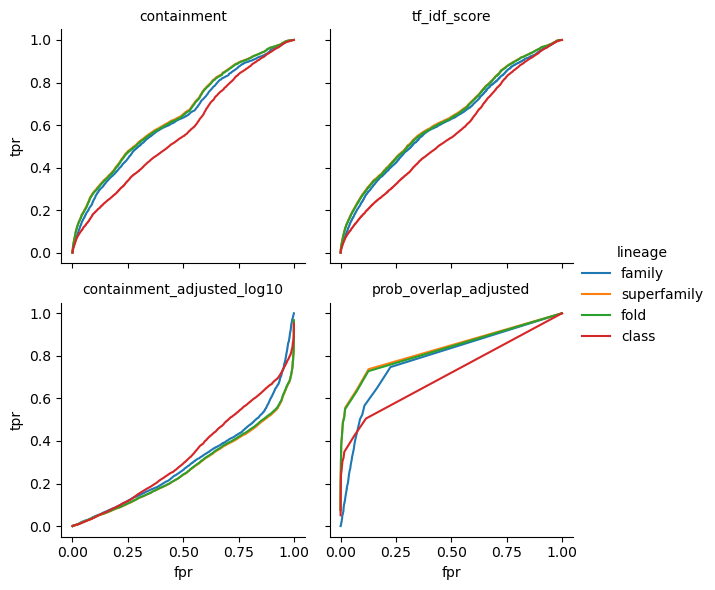

In [50]:
g = sns.relplot(
    data=roc_df,
    x="fpr",
    y="tpr",
    hue="lineage",
    col="score_name",
    height=3,
    col_wrap=2,
    kind="line",
)
g.set_titles("{col_name}")

### Plot DET Curve

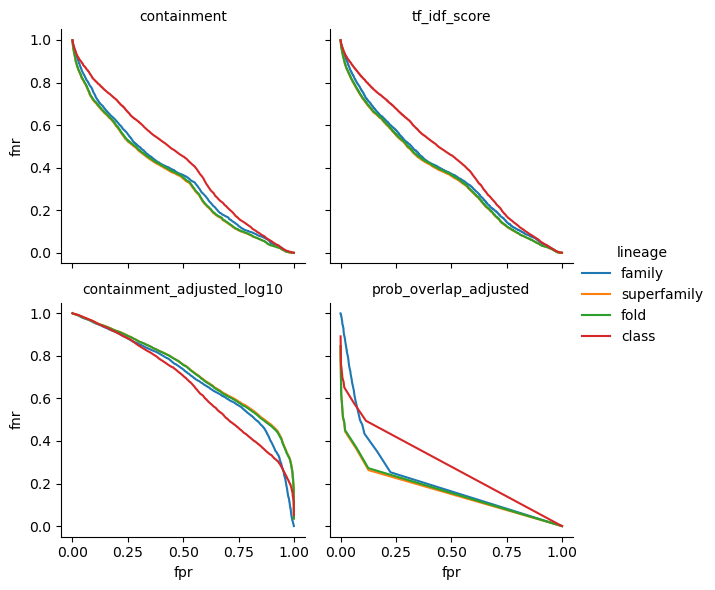

In [67]:
g = sns.relplot(
    data=det_df,
    x="fpr",
    y="fnr",
    hue="lineage",
    col="score_name",
    height=3,
    col_wrap=2,
    kind="line",
)
g.set_titles("{col_name}")

# Compute metrics across all ksizes

In [162]:
%%file evaluate_sourmash_multisearch.py

curve_dfs = {
    "precision_recall": [],
    "roc": [],
    "det": [],
}

lines = []


def make_curve_df_ksize_moltype(
    y_true,
    y_score,
    lineage,
    sourmash_score,
    curve: Literal["precision_recall", "roc", "det"],
    ksize: int,
    moltype: Literal["protein", "dayhoff", "hp"],
):
    df_maker = curve_df_makers[curve]
    df = df_maker(y_true, y_score)
    df["lineage"] = lineage_col
    df["sourmash_score"] = score_col
    df["moltype"] = moltype
    df["ksize"] = ksize
    return df


moltype = "protein"


binary_classification_scorers = {
    "average_precision": average_precision_score,
    "roc_auc": roc_auc_score,
    # "top_k_accuracy": top_k_accuracy_score,
}

multiclass_scorers = {
    "recall": lambda x, y: recall_score(x, y, average="macro"),
    "f1": lambda x, y: f1_score(x, y, average="macro"),
    "balanced_accuracy": balanced_accuracy_score,
    "accuracy": accuracy_score,
    # "top_k_accuracy": top_k_accuracy_score,
}

confusion_matrices = {}


def make_score_line(
    y_true, y_pred, sklearn_score_name, lineage, sourmash_score_name, ksize, moltype
):
    try:
        scorer = binary_classification_scorers[sklearn_score_name]
    except KeyError:
        scorer = multiclass_scorers[sklearn_score_name]
    score_value = scorer(y_true, y_pred)
    line = [
        moltype,
        ksize,
        lineage,
        sourmash_score_name,
        score_value,
        sklearn_score_name,
    ]
    return line


def make_precision_recall_fscore_support_df(
    y_true, y_pred, lineage, sourmash_score_name, ksize, moltype
):
    p, r, f, s = precision_recall_fscore_support(y_true, y_pred, average="macro")

    df = pd.DataFrame(dict(precision=p, recall=r, fscore=f, support=s))
    df["lineage"] = lineage
    df["sourmash_score"] = sourmash_score_name
    df["moltype"] = moltype
    df["ksize"] = ksize
    return df


lines = []
ksizes = range(7, 21)
for ksize in ksizes:
    print(f"--- ksize: {ksize} ---")
    pq = make_multisearch_pq(ksize, analysis_outdir, "protein")
    multisearch = pd.read_parquet(pq)
    # Take the inverse of probability of overlap, so that bigger is better
    multisearch["prob_overlap_adjusted"] = 1 / multisearch["prob_overlap_adjusted"]

    lineage_cols = ["family", "superfamily", "fold", "class"]

    for lineage_col in lineage_cols:
        query = f"query_{lineage_col}"
        match = f"match_{lineage_col}"

        multisearch[lineage_col] = multisearch[query] == multisearch[match]

    # Ignore self matches
    print(f"Before removing self-matches: {multisearch.shape}")
    multisearch_no_self = multisearch.query("query_name != match_name")
    print(f"After  removing self-matches: {multisearch_no_self.shape}")

    for lineage_col in lineage_cols:
        for sourmash_score_name in score_cols:
            y_true_bool = multisearch_no_self[lineage_col]

            y_true = multisearch_no_self[f"query_{lineage_col}"]
            y_pred = multisearch_no_self[f"match_{lineage_col}"]
            y_score = multisearch_no_self[sourmash_score_name]

            for sklearn_score in binary_classification_scorers.keys():
                try:
                    line = make_score_line(
                        y_true_bool,
                        y_score,
                        sklearn_score,
                        lineage_col,
                        sourmash_score_name,
                        ksize,
                        moltype,
                    )
                    lines.append(line)
                except ValueError:
                    # skip when ROC isn't defined, when only one class is present
                    pass

            for sklearn_score in multiclass_scorers.keys():
                # try:
                line = make_score_line(
                    y_true,
                    y_pred,
                    sklearn_score,
                    lineage_col,
                    sourmash_score_name,
                    ksize,
                    moltype,
                )
                lines.append(line)
                # except ValueError:
                #     # skip when ROC isn't defined, when only one class is present
                #     pass

            matrix = confusion_matrix(y_true, y_pred)
            key = (moltype, ksize, sourmash_score_name, lineage_col)
            confusion_matrices[key] = matrix

            for curve in curve_df_makers.keys():
                try:
                    with warnings.catch_warnings(action="ignore"):
                        # Ignore warnings that show up only one class in y_true
                        # UndefinedMetricWarning: No negative samples in y_true,
                        # false positive value should be meaningless
                        df = make_curve_df_ksize_moltype(
                            y_true_bool,
                            y_score,
                            lineage_col,
                            sourmash_score_name,
                            curve,
                            ksize,
                            moltype,
                        )

                        curve_dfs[curve].append(df)
                except ValueError:
                    # skip when ROC or DET aren't defined, when only one class is present
                    pass

classification_metrics = pd.DataFrame(
    lines,
    columns=["moltype", "ksize", "lineage", "sourmash_score", "metric", "metric_name"],
)
classification_metrics

Writing evaluate_sourmash_multisearch.py


In [155]:
classification_metrics.metric_name.value_counts()

metric_name
average_precision    224
recall               224
balanced_accuracy    224
f1                   224
accuracy             224
roc_auc              188
Name: count, dtype: int64

In [156]:
classification_metrics

,moltype,ksize,lineage,sourmash_score,metric,metric_name
0,protein,7,family,containment,0.311685,average_precision
1,protein,7,family,containment,0.631559,roc_auc
2,protein,7,family,containment,0.049119,recall
3,protein,7,family,containment,0.049119,f1
4,protein,7,family,containment,0.049119,balanced_accuracy
...,...,...,...,...,...,...
1303,protein,20,class,prob_overlap_adjusted,1.000000,average_precision
1304,protein,20,class,prob_overlap_adjusted,1.000000,recall
1305,protein,20,class,prob_overlap_adjusted,1.000000,f1
1306,protein,20,class,prob_overlap_adjusted,1.000000,balanced_accuracy


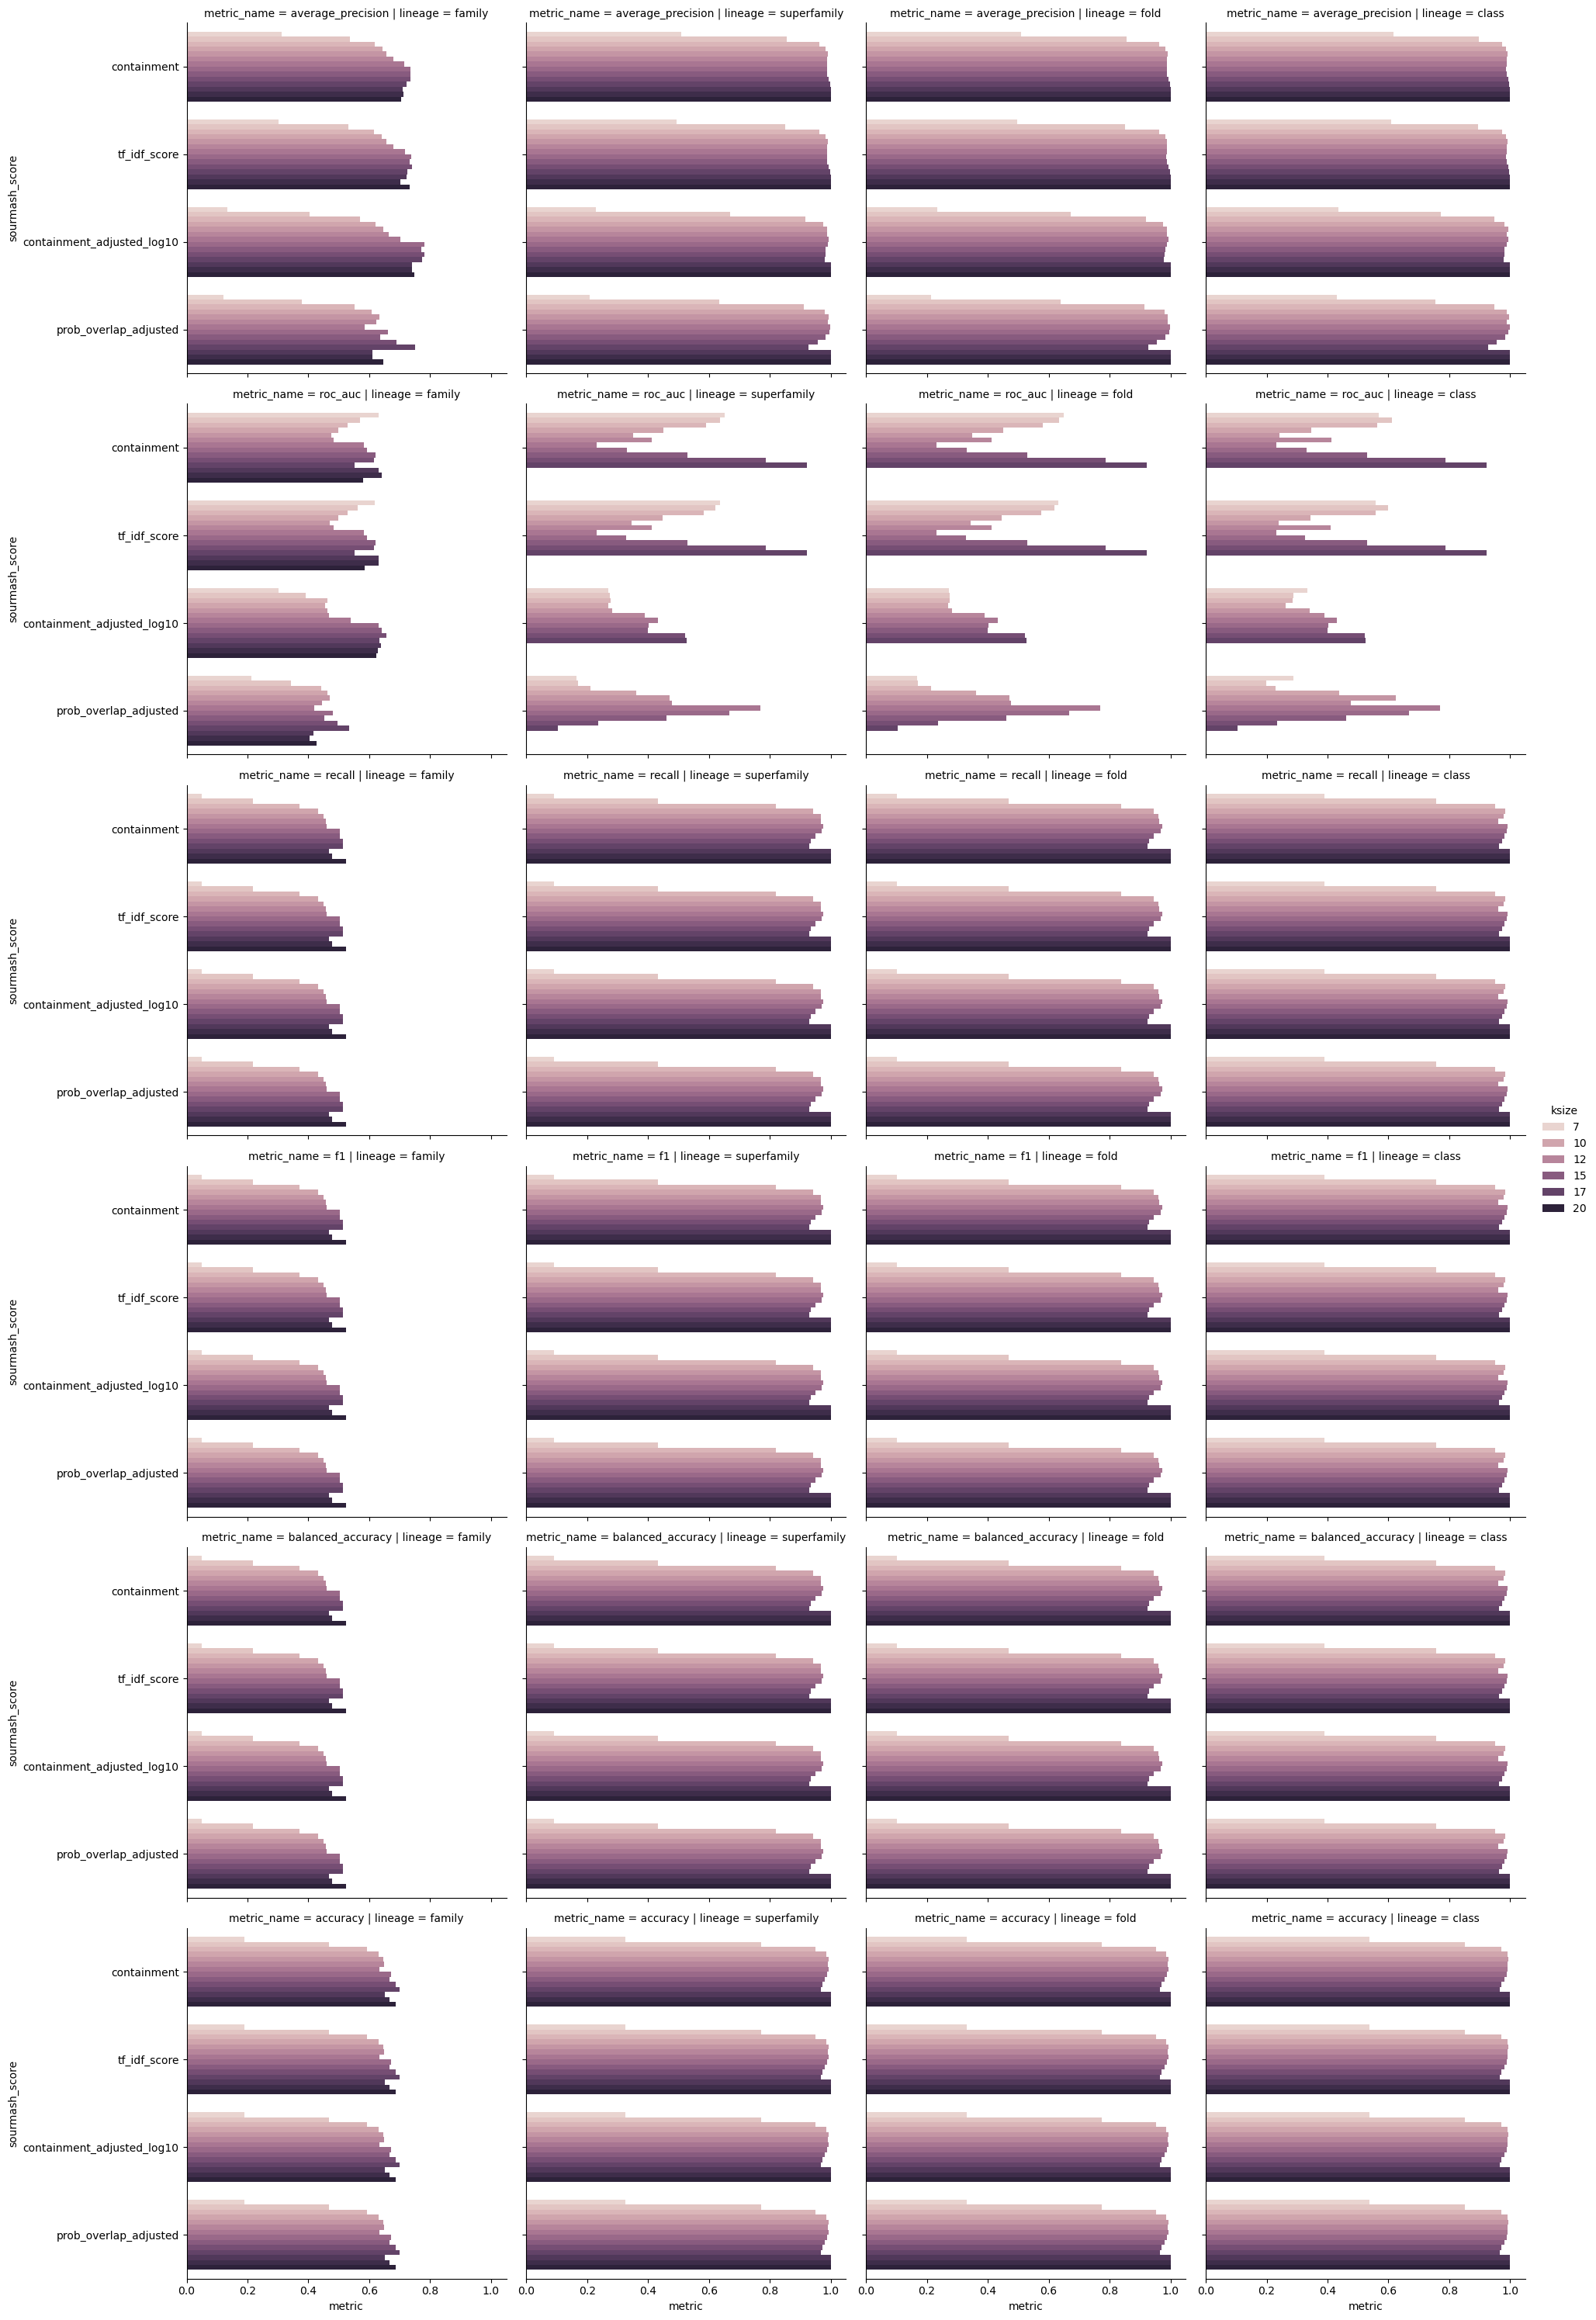

In [157]:
sns.catplot(
    data=classification_metrics,
    x="metric",
    hue="ksize",
    y="sourmash_score",
    col="lineage",
    row="metric_name",
    kind="bar",
    # palette="Set2",
)

In [158]:
classification_metrics.query('metric_name != "roc_auc"').groupby(
    ["metric_name", "lineage", "sourmash_score"]
).apply(lambda x: x.nlargest(1, "metric"))

/tmp/ipykernel_11181/2541944322.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(lambda x: x.nlargest(1, "metric"))


moltype  ksize  \
metric_name lineage     sourmash_score                                    
accuracy    class       containment                1124  protein     18   
                        containment_adjusted_log10 1134  protein     18   
                        prob_overlap_adjusted      1139  protein     18   
                        tf_idf_score               1129  protein     18   
            family      containment                965   protein     17   
...                                                          ...    ...   
recall      fold        tf_idf_score               1106  protein     18   
            superfamily containment                1081  protein     18   
                        containment_adjusted_log10 1091  protein     18   
                        prob_overlap_adjusted      1096  protein     18   
                        tf_idf_score               1086  protein     18   

                                                             lineage  \
metric_name lineage     sourmash_score                                 
accuracy    class       containment                1124        class   
                        containment_adjusted_log10 1134        class   
                        prob_overlap_adjusted      1139        class   
                        tf_idf_score               1129        class   
            family      containment                965        family   
...                                                              ...   
recall      fold        tf_idf_score               1106         fold   
            superfamily containment                1081  superfamily   
                        containment_adjusted_log10 1091  superfamily   
                        prob_overlap_adjusted      1096  superfamily   
                        tf_idf_score               1086  superfamily   

                                                                     sourmash_score  \
metric_name lineage     sourmash_score                                                
accuracy    class       containment                1124                 containment   
                        containment_adjusted_log10 1134  containment_adjusted_log10   
                        prob_overlap_adjusted      1139       prob_overlap_adjusted   
                        tf_idf_score               1129                tf_idf_score   
            family      containment                965                  containment   
...                                                                             ...   
recall      fold        tf_idf_score               1106                tf_idf_score   
            superfamily containment                1081                 containment   
                        containment_adjusted_log10 1091  containment_adjusted_log10   
                        prob_overlap_adjusted      1096       prob_overlap_adjusted   
                        tf_idf_score               1086                tf_idf_score   

                                                         metric metric_name  
metric_name lineage     sourmash_score                                       
accuracy    class       containment                1124     1.0    accuracy  
                        containment_adjusted_log10 1134     1.0    accuracy  
                        prob_overlap_adjusted      1139     1.0    accuracy  
                        tf_idf_score               1129     1.0    accuracy  
            family      containment                965      0.7    accuracy  
...                                                         ...         ...  
recall      fold        tf_idf_score               1106     1.0      recall  
            superfamily containment                1081     1.0      recall  
                        containment_adjusted_log10 1091     1.0      recall  
                        prob_overlap_adjusted      1096     1.0      recall  
                        tf_idf_score               1086     1.0      recall 

In [159]:
classification_metrics.query('metric_name == "roc_auc"').groupby(
    ["metric_name", "lineage", "sourmash_score"]
).apply(lambda x: x.nsmallest(1, "metric"))

/tmp/ipykernel_11181/2943551036.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(lambda x: x.nsmallest(1, "metric"))


moltype  ksize  \
metric_name lineage     sourmash_score                                    
roc_auc     class       containment                649   protein     13   
                        containment_adjusted_log10 373   protein     10   
                        prob_overlap_adjusted      1051  protein     17   
                        tf_idf_score               655   protein     13   
            family      containment                385   protein     11   
                        containment_adjusted_log10 13    protein      7   
                        prob_overlap_adjusted      19    protein      7   
                        tf_idf_score               391   protein     11   
            fold        containment                625   protein     13   
                        containment_adjusted_log10 349   protein     10   
                        prob_overlap_adjusted      1027  protein     17   
                        tf_idf_score               631   protein     13   
            superfamily containment                601   protein     13   
                        containment_adjusted_log10 325   protein     10   
                        prob_overlap_adjusted      1003  protein     17   
                        tf_idf_score               607   protein     13   

                                                             lineage  \
metric_name lineage     sourmash_score                                 
roc_auc     class       containment                649         class   
                        containment_adjusted_log10 373         class   
                        prob_overlap_adjusted      1051        class   
                        tf_idf_score               655         class   
            family      containment                385        family   
                        containment_adjusted_log10 13         family   
                        prob_overlap_adjusted      19         family   
                        tf_idf_score               391        family   
            fold        containment                625          fold   
                        containment_adjusted_log10 349          fold   
                        prob_overlap_adjusted      1027         fold   
                        tf_idf_score               631          fold   
            superfamily containment                601   superfamily   
                        containment_adjusted_log10 325   superfamily   
                        prob_overlap_adjusted      1003  superfamily   
                        tf_idf_score               607   superfamily   

                                                                     sourmash_score  \
metric_name lineage     sourmash_score                                                
roc_auc     class       containment                649                  containment   
                        containment_adjusted_log10 373   containment_adjusted_log10   
                        prob_overlap_adjusted      1051       prob_overlap_adjusted   
                        tf_idf_score               655                 tf_idf_score   
            family      containment                385                  containment   
                        containment_adjusted_log10 13    containment_adjusted_log10   
                        prob_overlap_adjusted      19         prob_overlap_adjusted   
                        tf_idf_score               391                 tf_idf_score   
            fold        containment                625                  containment   
                        containment_adjusted_log10 349   containment_adjusted_log10   
                        prob_overlap_adjusted      1027       prob_overlap_adjusted   
                        tf_idf_score               631                 tf_idf_score   
            superfamily containment                601                  containment   
                        containment_adjusted_log10 325   containment_adjusted_log10   
                 

## Concatenate curve dataframes

In [142]:
precision_recall_df = pd.concat(curve_dfs["precision_recall"])
print(precision_recall_df.shape)
precision_recall_df.head()

(116160, 7)


,precision,recall,thresholds,lineage,sourmash_score,moltype,ksize
0,0.190145,1.000000,0.000603,family,prob_overlap_adjusted,protein,7
1,0.190188,0.999863,0.000669,family,prob_overlap_adjusted,protein,7
2,0.190290,0.999727,0.000693,family,prob_overlap_adjusted,protein,7
3,0.190350,0.999727,0.000795,family,prob_overlap_adjusted,protein,7
4,0.190370,0.999727,0.000833,family,prob_overlap_adjusted,protein,7


In [143]:
det_df = pd.concat(curve_dfs["det"])
print(det_df.shape)
det_df.head()

(109677, 7)


,fpr,fnr,thresholds,lineage,sourmash_score,moltype,ksize
0,1.000000,0.000000,0.000603,family,prob_overlap_adjusted,protein,7
1,0.999583,0.000137,0.000669,family,prob_overlap_adjusted,protein,7
2,0.998780,0.000273,0.000693,family,prob_overlap_adjusted,protein,7
3,0.998395,0.000273,0.000795,family,prob_overlap_adjusted,protein,7
4,0.998267,0.000273,0.000833,family,prob_overlap_adjusted,protein,7


In [144]:
roc_df = pd.concat(curve_dfs["roc"])
print(roc_df.shape)
roc_df.head()

(80654, 7)


,fpr,tpr,thresholds,lineage,sourmash_score,moltype,ksize
0,0.000000,0.000000,inf,family,prob_overlap_adjusted,protein,7
1,0.000064,0.000410,1.000000,family,prob_overlap_adjusted,protein,7
2,0.000064,0.000683,0.833333,family,prob_overlap_adjusted,protein,7
3,0.000096,0.000683,0.818182,family,prob_overlap_adjusted,protein,7
4,0.000096,0.001914,0.170543,family,prob_overlap_adjusted,protein,7


## Plot curves across SCOP lineages and sourmash match scores (containment, tf-idf score, adjusted containment, probability of overlap)

### Plot Precision Recall

In [161]:
precision_recall_df.query('lineage == "family"').sourmash_score.value_counts()

sourmash_score
prob_overlap_adjusted    29040
Name: count, dtype: int64

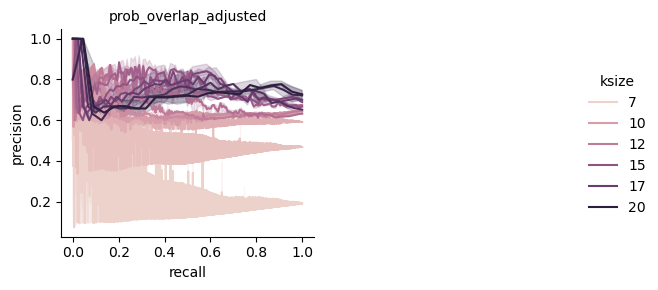

In [146]:
g = sns.relplot(
    data=precision_recall_df.query('lineage == "family"'),
    x="recall",
    y="precision",
    hue="ksize",
    col="sourmash_score",
    height=3,
    col_wrap=2,
    # kind="line",
)
g.set_titles("{col_name}")

### Plot ROC AUC

In [147]:
g = sns.relplot(
    data=precision_recall_df.query('lineage == "family"'),
    x="fpr",
    y="tpr",
    hue="ksize",
    col="sourmash_score",
    height=3,
    col_wrap=2,
    kind="line",
)
g.set_titles("{col_name}")

ValueError: Could not interpret value `fpr` for `x`. An entry with this name does not appear in `data`.

### Plot DET Curve

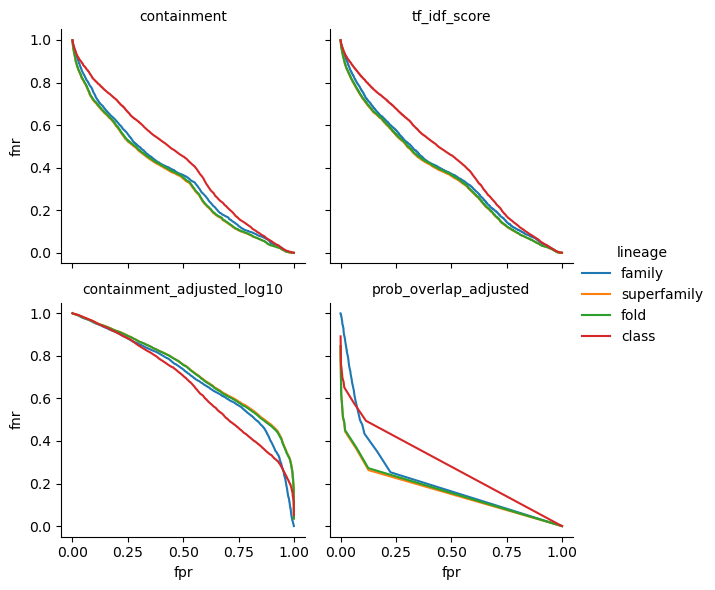

In [67]:
g = sns.relplot(
    data=det_df,
    x="fpr",
    y="fnr",
    hue="lineage",
    col="score_name",
    height=3,
    col_wrap=2,
    kind="line",
)
g.set_titles("{col_name}")